In [1]:
import os
import numpy as np
from tqdm import tqdm
import copy
import boto3

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

from models import MobileNetV3
from data_preparation import CreateDataset, load_images_and_labels, encode_labels, create_data_augmentation
from trainer import prune_model, remove_pruning, count_nonzero_parameters, store_pruning_masks, reapply_pruning_masks, evaluate_model, plot_losses

import multiprocessing

import pickle

num_workers = multiprocessing.cpu_count()

batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_num_threads(num_workers)

/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = "ck"

bucket_name = 'thesissagemakerbucket'
train_path = f'{data}/train'
test_path = f'{data}/test'

X_train, y_train = load_images_and_labels(bucket_name, train_path)
X_test, y_test = load_images_and_labels(bucket_name, test_path)

In [3]:
X = X_train + X_test
y = y_train + y_test

# split into training and testing data using sklearn
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_test_and_val,
                                                y_test_and_val,
                                                test_size=0.5,
                                                random_state=42)

In [4]:
# label_encoder, y_train, y_test = encode_labels(y_train, y_test)
label_encoder, y_train, y_val, y_test = encode_labels(y_train, y_val, y_test)


In [5]:
transform = create_data_augmentation()

train_dataset = CreateDataset(X_train, y_train, transform=transform)
test_dataset = CreateDataset(X_test, y_test, transform=transform)
val_dataset = CreateDataset(X_val, y_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [6]:
model = MobileNetV3(num_labels=len(label_encoder.classes_)).to(device)

/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [8]:
def train_model(model,
                train_loader,
                val_loader,
                criterion,
                optimizer,
                device,
                epochs,
                prune_percent=0.2,
                total_prune_cycles=100,
                patience=3,
                cycle_patience=3):

    best_models_dict = {}
    best_model_wts = copy.deepcopy(model.state_dict())
    global_best_val_loss = np.inf
    train_losses = []
    val_losses = []

    initial_params = count_nonzero_parameters(model)
    print(f"Initial non-zero parameters: {initial_params}")

    no_improvement_cycles = 0

    for cycle in range(total_prune_cycles):
        print(f"Pruning cycle {cycle + 1}/{total_prune_cycles}")

        current_params = count_nonzero_parameters(model)
        print(f"Params before cycle {cycle + 1}: {current_params}")

        cycle_best_val_loss = np.inf
        cycle_best_model_wts = copy.deepcopy(model.state_dict())
        no_improvement_epochs = 0

        for epoch in range(epochs):
            model.train()
            total_train_loss = 0

            for images, labels in tqdm(train_loader, desc=f"Cycle {cycle + 1}, Epoch {epoch + 1}"):
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()

                for name, param in model.named_parameters():
                    if hasattr(param, 'mask'):
                        param.grad *= param.mask

                optimizer.step()

                total_train_loss += loss.item()

                del images, labels, outputs, loss
                torch.cuda.empty_cache()

            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    total_val_loss += loss.item()

                    del images, labels, outputs, loss
                    torch.cuda.empty_cache()

            avg_val_loss = total_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

            if avg_val_loss < cycle_best_val_loss:
                cycle_best_val_loss = avg_val_loss
                pruning_masks = store_pruning_masks(model)
                remove_pruning(model)
                cycle_best_model_wts = copy.deepcopy(model.state_dict())
                reapply_pruning_masks(model, pruning_masks)
                no_improvement_epochs = 0
            else:
                no_improvement_epochs += 1

            if avg_val_loss < global_best_val_loss:
                global_best_val_loss = avg_val_loss
                pruning_masks = store_pruning_masks(model)
                remove_pruning(model)
                cycle_best_model_wts = copy.deepcopy(model.state_dict())
                reapply_pruning_masks(model, pruning_masks)

            if no_improvement_epochs >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1} of cycle {cycle + 1}")
                break

        print(f"Cycle best loss: {cycle_best_val_loss}")
        print(f"Global best loss: {global_best_val_loss}")
        if cycle_best_val_loss == global_best_val_loss:
            global_best_val_loss = cycle_best_val_loss
            no_improvement_cycles = 0
            print(f"New global best validation loss: {global_best_val_loss:.4f} at cycle {cycle + 1}")
        else:
            no_improvement_cycles += 1
            print(f"No improvement in cycle {cycle + 1}. Cycle patience: {no_improvement_cycles}/{cycle_patience}")

        if no_improvement_cycles >= cycle_patience:
            print(f"Early stopping after {cycle + 1} cycles with no improvement.")
            break

        pruning_masks = store_pruning_masks(model)
        remove_pruning(model)
        
        model.load_state_dict(cycle_best_model_wts)
            
        best_models_dict[cycle + 1] = {
            'cycle': cycle + 1,
            'model': copy.deepcopy(model.state_dict()),
            'params': count_nonzero_parameters(model),
            'min_val_loss': cycle_best_val_loss
        }
        
        reapply_pruning_masks(model, pruning_masks)
        
        try:
            prune_model(model, prune_percent)
        except:
            print("Achieved max amount for pruning")
            current_params = count_nonzero_parameters(model)
            print(f"Parameters after cycle {cycle + 1}: {current_params}")
            break

        current_params = count_nonzero_parameters(model)
        print(f"Parameters after cycle {cycle + 1}: {current_params}")

    remove_pruning(model)
    model.load_state_dict(best_model_wts)

    final_params = count_nonzero_parameters(model)
    print(f"Best model count of paramenters: {final_params}")

    return model, best_models_dict, train_losses, val_losses

model, best_models_dict, train_loss, val_loss = train_model(
                                   model=model,
                                   train_loader=train_loader,
                                   val_loader=val_loader,
                                   criterion=criterion,
                                   optimizer=optimizer,
                                   device=device,
                                   epochs=500,
                                   patience=10,
                                   prune_percent=0.1,
                                   total_prune_cycles=20,
                                   cycle_patience=10)

Initial non-zero parameters: 1515056
Pruning cycle 1/20
Params before cycle 1: 1515056


Cycle 1, Epoch 1: 100%|██████████| 16/16 [00:02<00:00,  5.73it/s]


Epoch 1, Train Loss: 1.8087, Validation Loss: 1.7866


Cycle 1, Epoch 2: 100%|██████████| 16/16 [00:02<00:00,  6.94it/s]


Epoch 2, Train Loss: 1.5453, Validation Loss: 1.5828


Cycle 1, Epoch 3: 100%|██████████| 16/16 [00:02<00:00,  7.00it/s]


Epoch 3, Train Loss: 1.3480, Validation Loss: 1.4092


Cycle 1, Epoch 4: 100%|██████████| 16/16 [00:02<00:00,  6.66it/s]


Epoch 4, Train Loss: 1.1671, Validation Loss: 1.2767


Cycle 1, Epoch 5: 100%|██████████| 16/16 [00:02<00:00,  7.12it/s]


Epoch 5, Train Loss: 0.9757, Validation Loss: 1.1608


Cycle 1, Epoch 6: 100%|██████████| 16/16 [00:02<00:00,  7.17it/s]


Epoch 6, Train Loss: 0.8059, Validation Loss: 1.1408


Cycle 1, Epoch 7: 100%|██████████| 16/16 [00:02<00:00,  7.13it/s]


Epoch 7, Train Loss: 0.6767, Validation Loss: 1.1383


Cycle 1, Epoch 8: 100%|██████████| 16/16 [00:02<00:00,  7.08it/s]


Epoch 8, Train Loss: 0.5582, Validation Loss: 1.1452


Cycle 1, Epoch 9: 100%|██████████| 16/16 [00:02<00:00,  7.05it/s]


Epoch 9, Train Loss: 0.4724, Validation Loss: 1.1270


Cycle 1, Epoch 10: 100%|██████████| 16/16 [00:02<00:00,  7.17it/s]


Epoch 10, Train Loss: 0.3858, Validation Loss: 1.0876


Cycle 1, Epoch 11: 100%|██████████| 16/16 [00:02<00:00,  7.18it/s]


Epoch 11, Train Loss: 0.3082, Validation Loss: 1.0991


Cycle 1, Epoch 12: 100%|██████████| 16/16 [00:02<00:00,  7.22it/s]


Epoch 12, Train Loss: 0.2608, Validation Loss: 1.0118


Cycle 1, Epoch 13: 100%|██████████| 16/16 [00:02<00:00,  7.13it/s]


Epoch 13, Train Loss: 0.2126, Validation Loss: 0.9382


Cycle 1, Epoch 14: 100%|██████████| 16/16 [00:02<00:00,  7.18it/s]


Epoch 14, Train Loss: 0.1913, Validation Loss: 0.8115


Cycle 1, Epoch 15: 100%|██████████| 16/16 [00:02<00:00,  7.10it/s]


Epoch 15, Train Loss: 0.1648, Validation Loss: 0.7757


Cycle 1, Epoch 16: 100%|██████████| 16/16 [00:02<00:00,  7.18it/s]


Epoch 16, Train Loss: 0.1515, Validation Loss: 0.7387


Cycle 1, Epoch 17: 100%|██████████| 16/16 [00:02<00:00,  7.07it/s]


Epoch 17, Train Loss: 0.1230, Validation Loss: 0.6506


Cycle 1, Epoch 18: 100%|██████████| 16/16 [00:02<00:00,  7.03it/s]


Epoch 18, Train Loss: 0.1178, Validation Loss: 0.5644


Cycle 1, Epoch 19: 100%|██████████| 16/16 [00:02<00:00,  7.05it/s]


Epoch 19, Train Loss: 0.0932, Validation Loss: 0.6205


Cycle 1, Epoch 20: 100%|██████████| 16/16 [00:02<00:00,  7.14it/s]


Epoch 20, Train Loss: 0.0927, Validation Loss: 0.5628


Cycle 1, Epoch 21: 100%|██████████| 16/16 [00:02<00:00,  7.15it/s]


Epoch 21, Train Loss: 0.0674, Validation Loss: 0.5373


Cycle 1, Epoch 22: 100%|██████████| 16/16 [00:02<00:00,  6.91it/s]


Epoch 22, Train Loss: 0.0717, Validation Loss: 0.5099


Cycle 1, Epoch 23: 100%|██████████| 16/16 [00:02<00:00,  7.10it/s]


Epoch 23, Train Loss: 0.0514, Validation Loss: 0.5459


Cycle 1, Epoch 24: 100%|██████████| 16/16 [00:02<00:00,  7.17it/s]


Epoch 24, Train Loss: 0.0426, Validation Loss: 0.6421


Cycle 1, Epoch 25: 100%|██████████| 16/16 [00:02<00:00,  7.10it/s]


Epoch 25, Train Loss: 0.0373, Validation Loss: 0.6327


Cycle 1, Epoch 26: 100%|██████████| 16/16 [00:02<00:00,  7.16it/s]


Epoch 26, Train Loss: 0.0490, Validation Loss: 0.5467


Cycle 1, Epoch 27: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s]


Epoch 27, Train Loss: 0.0349, Validation Loss: 0.4760


Cycle 1, Epoch 28: 100%|██████████| 16/16 [00:02<00:00,  6.87it/s]


Epoch 28, Train Loss: 0.0281, Validation Loss: 0.4871


Cycle 1, Epoch 29: 100%|██████████| 16/16 [00:02<00:00,  6.98it/s]


Epoch 29, Train Loss: 0.0321, Validation Loss: 0.4305


Cycle 1, Epoch 30: 100%|██████████| 16/16 [00:02<00:00,  6.70it/s]


Epoch 30, Train Loss: 0.0220, Validation Loss: 0.4057


Cycle 1, Epoch 31: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s]


Epoch 31, Train Loss: 0.0208, Validation Loss: 0.4376


Cycle 1, Epoch 32: 100%|██████████| 16/16 [00:02<00:00,  6.66it/s]


Epoch 32, Train Loss: 0.0258, Validation Loss: 0.4728


Cycle 1, Epoch 33: 100%|██████████| 16/16 [00:02<00:00,  6.82it/s]


Epoch 33, Train Loss: 0.0143, Validation Loss: 0.4213


Cycle 1, Epoch 34: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]


Epoch 34, Train Loss: 0.0215, Validation Loss: 0.3746


Cycle 1, Epoch 35: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s]


Epoch 35, Train Loss: 0.0138, Validation Loss: 0.2497


Cycle 1, Epoch 36: 100%|██████████| 16/16 [00:02<00:00,  6.91it/s]


Epoch 36, Train Loss: 0.0130, Validation Loss: 0.2753


Cycle 1, Epoch 37: 100%|██████████| 16/16 [00:02<00:00,  6.61it/s]


Epoch 37, Train Loss: 0.0120, Validation Loss: 0.2917


Cycle 1, Epoch 38: 100%|██████████| 16/16 [00:02<00:00,  6.94it/s]


Epoch 38, Train Loss: 0.0108, Validation Loss: 0.2238


Cycle 1, Epoch 39: 100%|██████████| 16/16 [00:02<00:00,  6.74it/s]


Epoch 39, Train Loss: 0.0078, Validation Loss: 0.2807


Cycle 1, Epoch 40: 100%|██████████| 16/16 [00:02<00:00,  7.10it/s]


Epoch 40, Train Loss: 0.0088, Validation Loss: 0.2602


Cycle 1, Epoch 41: 100%|██████████| 16/16 [00:02<00:00,  6.93it/s]


Epoch 41, Train Loss: 0.0111, Validation Loss: 0.2057


Cycle 1, Epoch 42: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]


Epoch 42, Train Loss: 0.0061, Validation Loss: 0.1887


Cycle 1, Epoch 43: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]


Epoch 43, Train Loss: 0.0067, Validation Loss: 0.1760


Cycle 1, Epoch 44: 100%|██████████| 16/16 [00:02<00:00,  7.08it/s]


Epoch 44, Train Loss: 0.0073, Validation Loss: 0.1763


Cycle 1, Epoch 45: 100%|██████████| 16/16 [00:02<00:00,  7.23it/s]


Epoch 45, Train Loss: 0.0051, Validation Loss: 0.1575


Cycle 1, Epoch 46: 100%|██████████| 16/16 [00:02<00:00,  7.03it/s]


Epoch 46, Train Loss: 0.0064, Validation Loss: 0.2147


Cycle 1, Epoch 47: 100%|██████████| 16/16 [00:02<00:00,  7.11it/s]


Epoch 47, Train Loss: 0.0073, Validation Loss: 0.1947


Cycle 1, Epoch 48: 100%|██████████| 16/16 [00:02<00:00,  6.93it/s]


Epoch 48, Train Loss: 0.0058, Validation Loss: 0.2153


Cycle 1, Epoch 49: 100%|██████████| 16/16 [00:02<00:00,  7.12it/s]


Epoch 49, Train Loss: 0.0049, Validation Loss: 0.1908


Cycle 1, Epoch 50: 100%|██████████| 16/16 [00:02<00:00,  6.88it/s]


Epoch 50, Train Loss: 0.0060, Validation Loss: 0.1642


Cycle 1, Epoch 51: 100%|██████████| 16/16 [00:02<00:00,  7.23it/s]


Epoch 51, Train Loss: 0.0042, Validation Loss: 0.2107


Cycle 1, Epoch 52: 100%|██████████| 16/16 [00:02<00:00,  7.10it/s]


Epoch 52, Train Loss: 0.0043, Validation Loss: 0.1358


Cycle 1, Epoch 53: 100%|██████████| 16/16 [00:02<00:00,  7.18it/s]


Epoch 53, Train Loss: 0.0032, Validation Loss: 0.1645


Cycle 1, Epoch 54: 100%|██████████| 16/16 [00:02<00:00,  7.11it/s]


Epoch 54, Train Loss: 0.0041, Validation Loss: 0.1409


Cycle 1, Epoch 55: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]


Epoch 55, Train Loss: 0.0056, Validation Loss: 0.1744


Cycle 1, Epoch 56: 100%|██████████| 16/16 [00:02<00:00,  6.96it/s]


Epoch 56, Train Loss: 0.0080, Validation Loss: 0.1403


Cycle 1, Epoch 57: 100%|██████████| 16/16 [00:02<00:00,  6.90it/s]


Epoch 57, Train Loss: 0.0118, Validation Loss: 0.1711


Cycle 1, Epoch 58: 100%|██████████| 16/16 [00:02<00:00,  6.89it/s]


Epoch 58, Train Loss: 0.0047, Validation Loss: 0.2271


Cycle 1, Epoch 59: 100%|██████████| 16/16 [00:02<00:00,  6.94it/s]


Epoch 59, Train Loss: 0.0024, Validation Loss: 0.1607


Cycle 1, Epoch 60: 100%|██████████| 16/16 [00:02<00:00,  7.15it/s]


Epoch 60, Train Loss: 0.0026, Validation Loss: 0.1657


Cycle 1, Epoch 61: 100%|██████████| 16/16 [00:02<00:00,  7.07it/s]


Epoch 61, Train Loss: 0.0047, Validation Loss: 0.1752


Cycle 1, Epoch 62: 100%|██████████| 16/16 [00:02<00:00,  7.20it/s]


Epoch 62, Train Loss: 0.0111, Validation Loss: 0.1978
Early stopping triggered at epoch 62 of cycle 1
Cycle best loss: 0.13578057079575956
Global best loss: 0.13578057079575956
New global best validation loss: 0.1358 at cycle 1
Parameters after cycle 1: 1364157
Pruning cycle 2/20
Params before cycle 2: 1364157


Cycle 2, Epoch 1: 100%|██████████| 16/16 [00:02<00:00,  6.59it/s]


Epoch 1, Train Loss: 0.0085, Validation Loss: 0.2621


Cycle 2, Epoch 2: 100%|██████████| 16/16 [00:02<00:00,  6.95it/s]


Epoch 2, Train Loss: 0.0121, Validation Loss: 0.2700


Cycle 2, Epoch 3: 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]


Epoch 3, Train Loss: 0.0102, Validation Loss: 0.2409


Cycle 2, Epoch 4: 100%|██████████| 16/16 [00:02<00:00,  7.08it/s]


Epoch 4, Train Loss: 0.0096, Validation Loss: 0.1671


Cycle 2, Epoch 5: 100%|██████████| 16/16 [00:02<00:00,  6.93it/s]


Epoch 5, Train Loss: 0.0065, Validation Loss: 0.2420


Cycle 2, Epoch 6: 100%|██████████| 16/16 [00:02<00:00,  6.82it/s]


Epoch 6, Train Loss: 0.0033, Validation Loss: 0.1325


Cycle 2, Epoch 7: 100%|██████████| 16/16 [00:02<00:00,  7.06it/s]


Epoch 7, Train Loss: 0.0033, Validation Loss: 0.2284


Cycle 2, Epoch 8: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s]


Epoch 8, Train Loss: 0.0027, Validation Loss: 0.1515


Cycle 2, Epoch 9: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s]


Epoch 9, Train Loss: 0.0038, Validation Loss: 0.1453


Cycle 2, Epoch 10: 100%|██████████| 16/16 [00:02<00:00,  6.82it/s]


Epoch 10, Train Loss: 0.0033, Validation Loss: 0.1934


Cycle 2, Epoch 11: 100%|██████████| 16/16 [00:02<00:00,  6.78it/s]


Epoch 11, Train Loss: 0.0055, Validation Loss: 0.2329


Cycle 2, Epoch 12: 100%|██████████| 16/16 [00:02<00:00,  6.97it/s]


Epoch 12, Train Loss: 0.0020, Validation Loss: 0.1748


Cycle 2, Epoch 13: 100%|██████████| 16/16 [00:02<00:00,  6.97it/s]


Epoch 13, Train Loss: 0.0047, Validation Loss: 0.1878


Cycle 2, Epoch 14: 100%|██████████| 16/16 [00:02<00:00,  7.22it/s]


Epoch 14, Train Loss: 0.0025, Validation Loss: 0.2190


Cycle 2, Epoch 15: 100%|██████████| 16/16 [00:02<00:00,  7.00it/s]


Epoch 15, Train Loss: 0.0065, Validation Loss: 0.1957


Cycle 2, Epoch 16: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]


Epoch 16, Train Loss: 0.0042, Validation Loss: 0.1831
Early stopping triggered at epoch 16 of cycle 2
Cycle best loss: 0.13250812410842627
Global best loss: 0.13250812410842627
New global best validation loss: 0.1325 at cycle 2
Parameters after cycle 2: 1228348
Pruning cycle 3/20
Params before cycle 3: 1228348


Cycle 3, Epoch 1: 100%|██████████| 16/16 [00:02<00:00,  6.89it/s]


Epoch 1, Train Loss: 0.0091, Validation Loss: 1.3811


Cycle 3, Epoch 2: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]


Epoch 2, Train Loss: 0.0036, Validation Loss: 1.2397


Cycle 3, Epoch 3: 100%|██████████| 16/16 [00:02<00:00,  6.86it/s]


Epoch 3, Train Loss: 0.0073, Validation Loss: 0.7564


Cycle 3, Epoch 4: 100%|██████████| 16/16 [00:02<00:00,  6.96it/s]


Epoch 4, Train Loss: 0.0055, Validation Loss: 0.6489


Cycle 3, Epoch 5: 100%|██████████| 16/16 [00:02<00:00,  6.85it/s]


Epoch 5, Train Loss: 0.0063, Validation Loss: 0.4676


Cycle 3, Epoch 6: 100%|██████████| 16/16 [00:02<00:00,  7.07it/s]


Epoch 6, Train Loss: 0.0067, Validation Loss: 0.4047


Cycle 3, Epoch 7: 100%|██████████| 16/16 [00:02<00:00,  6.97it/s]


Epoch 7, Train Loss: 0.0040, Validation Loss: 0.2738


Cycle 3, Epoch 8: 100%|██████████| 16/16 [00:02<00:00,  7.13it/s]


Epoch 8, Train Loss: 0.0067, Validation Loss: 0.2105


Cycle 3, Epoch 9: 100%|██████████| 16/16 [00:02<00:00,  7.21it/s]


Epoch 9, Train Loss: 0.0059, Validation Loss: 0.2790


Cycle 3, Epoch 10: 100%|██████████| 16/16 [00:02<00:00,  7.05it/s]


Epoch 10, Train Loss: 0.0029, Validation Loss: 0.3013


Cycle 3, Epoch 11: 100%|██████████| 16/16 [00:02<00:00,  7.14it/s]


Epoch 11, Train Loss: 0.0080, Validation Loss: 0.2395


Cycle 3, Epoch 12: 100%|██████████| 16/16 [00:02<00:00,  6.74it/s]


Epoch 12, Train Loss: 0.0037, Validation Loss: 0.2869


Cycle 3, Epoch 13: 100%|██████████| 16/16 [00:02<00:00,  7.18it/s]


Epoch 13, Train Loss: 0.0039, Validation Loss: 0.2373


Cycle 3, Epoch 14: 100%|██████████| 16/16 [00:02<00:00,  7.12it/s]


Epoch 14, Train Loss: 0.0034, Validation Loss: 0.1474


Cycle 3, Epoch 15: 100%|██████████| 16/16 [00:02<00:00,  7.19it/s]


Epoch 15, Train Loss: 0.0017, Validation Loss: 0.1703


Cycle 3, Epoch 16: 100%|██████████| 16/16 [00:02<00:00,  7.01it/s]


Epoch 16, Train Loss: 0.0027, Validation Loss: 0.2007


Cycle 3, Epoch 17: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]


Epoch 17, Train Loss: 0.0023, Validation Loss: 0.1917


Cycle 3, Epoch 18: 100%|██████████| 16/16 [00:02<00:00,  6.71it/s]


Epoch 18, Train Loss: 0.0019, Validation Loss: 0.2177


Cycle 3, Epoch 19: 100%|██████████| 16/16 [00:02<00:00,  7.14it/s]


Epoch 19, Train Loss: 0.0020, Validation Loss: 0.1844


Cycle 3, Epoch 20: 100%|██████████| 16/16 [00:02<00:00,  7.08it/s]


Epoch 20, Train Loss: 0.0024, Validation Loss: 0.1861


Cycle 3, Epoch 21: 100%|██████████| 16/16 [00:02<00:00,  6.88it/s]


Epoch 21, Train Loss: 0.0010, Validation Loss: 0.1696


Cycle 3, Epoch 22: 100%|██████████| 16/16 [00:02<00:00,  6.99it/s]


Epoch 22, Train Loss: 0.0023, Validation Loss: 0.1960


Cycle 3, Epoch 23: 100%|██████████| 16/16 [00:02<00:00,  7.08it/s]


Epoch 23, Train Loss: 0.0058, Validation Loss: 0.1959


Cycle 3, Epoch 24: 100%|██████████| 16/16 [00:02<00:00,  6.95it/s]


Epoch 24, Train Loss: 0.0027, Validation Loss: 0.1788
Early stopping triggered at epoch 24 of cycle 3
Cycle best loss: 0.14735191325598862
Global best loss: 0.13250812410842627
No improvement in cycle 3. Cycle patience: 1/10
Parameters after cycle 3: 1106117
Pruning cycle 4/20
Params before cycle 4: 1106117


Cycle 4, Epoch 1: 100%|██████████| 16/16 [00:02<00:00,  6.77it/s]


Epoch 1, Train Loss: 0.0052, Validation Loss: 2.3669


Cycle 4, Epoch 2: 100%|██████████| 16/16 [00:02<00:00,  7.17it/s]


Epoch 2, Train Loss: 0.0160, Validation Loss: 1.8603


Cycle 4, Epoch 3: 100%|██████████| 16/16 [00:02<00:00,  7.17it/s]


Epoch 3, Train Loss: 0.0234, Validation Loss: 1.4954


Cycle 4, Epoch 4: 100%|██████████| 16/16 [00:02<00:00,  6.91it/s]


Epoch 4, Train Loss: 0.0178, Validation Loss: 1.2469


Cycle 4, Epoch 5: 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]


Epoch 5, Train Loss: 0.0154, Validation Loss: 0.7760


Cycle 4, Epoch 6: 100%|██████████| 16/16 [00:02<00:00,  7.04it/s]


Epoch 6, Train Loss: 0.0050, Validation Loss: 0.3687


Cycle 4, Epoch 7: 100%|██████████| 16/16 [00:02<00:00,  7.22it/s]


Epoch 7, Train Loss: 0.0138, Validation Loss: 0.4322


Cycle 4, Epoch 8: 100%|██████████| 16/16 [00:02<00:00,  6.94it/s]


Epoch 8, Train Loss: 0.0079, Validation Loss: 0.2285


Cycle 4, Epoch 9: 100%|██████████| 16/16 [00:02<00:00,  7.02it/s]


Epoch 9, Train Loss: 0.0051, Validation Loss: 0.2541


Cycle 4, Epoch 10: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Epoch 10, Train Loss: 0.0046, Validation Loss: 0.1531


Cycle 4, Epoch 11: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s]


Epoch 11, Train Loss: 0.0021, Validation Loss: 0.1961


Cycle 4, Epoch 12: 100%|██████████| 16/16 [00:02<00:00,  7.11it/s]


Epoch 12, Train Loss: 0.0071, Validation Loss: 0.2632


Cycle 4, Epoch 13: 100%|██████████| 16/16 [00:02<00:00,  7.19it/s]


Epoch 13, Train Loss: 0.0065, Validation Loss: 0.2848


Cycle 4, Epoch 14: 100%|██████████| 16/16 [00:02<00:00,  6.86it/s]


Epoch 14, Train Loss: 0.0021, Validation Loss: 0.2541


Cycle 4, Epoch 15: 100%|██████████| 16/16 [00:02<00:00,  6.96it/s]


Epoch 15, Train Loss: 0.0028, Validation Loss: 0.2153


Cycle 4, Epoch 16: 100%|██████████| 16/16 [00:02<00:00,  7.13it/s]


Epoch 16, Train Loss: 0.0037, Validation Loss: 0.1799


Cycle 4, Epoch 17: 100%|██████████| 16/16 [00:02<00:00,  7.12it/s]


Epoch 17, Train Loss: 0.0029, Validation Loss: 0.1522


Cycle 4, Epoch 18: 100%|██████████| 16/16 [00:02<00:00,  7.02it/s]


Epoch 18, Train Loss: 0.0026, Validation Loss: 0.2029


Cycle 4, Epoch 19: 100%|██████████| 16/16 [00:02<00:00,  7.13it/s]


Epoch 19, Train Loss: 0.0029, Validation Loss: 0.1477


Cycle 4, Epoch 20: 100%|██████████| 16/16 [00:02<00:00,  7.06it/s]


Epoch 20, Train Loss: 0.0035, Validation Loss: 0.1598


Cycle 4, Epoch 21: 100%|██████████| 16/16 [00:02<00:00,  7.10it/s]


Epoch 21, Train Loss: 0.0023, Validation Loss: 0.1524


Cycle 4, Epoch 22: 100%|██████████| 16/16 [00:02<00:00,  7.05it/s]


Epoch 22, Train Loss: 0.0027, Validation Loss: 0.1631


Cycle 4, Epoch 23: 100%|██████████| 16/16 [00:02<00:00,  7.18it/s]


Epoch 23, Train Loss: 0.0043, Validation Loss: 0.1743


Cycle 4, Epoch 24: 100%|██████████| 16/16 [00:02<00:00,  7.16it/s]


Epoch 24, Train Loss: 0.0050, Validation Loss: 0.1912


Cycle 4, Epoch 25: 100%|██████████| 16/16 [00:02<00:00,  7.08it/s]


Epoch 25, Train Loss: 0.0110, Validation Loss: 0.1210


Cycle 4, Epoch 26: 100%|██████████| 16/16 [00:02<00:00,  6.96it/s]


Epoch 26, Train Loss: 0.0040, Validation Loss: 0.1590


Cycle 4, Epoch 27: 100%|██████████| 16/16 [00:02<00:00,  6.78it/s]


Epoch 27, Train Loss: 0.0055, Validation Loss: 0.2105


Cycle 4, Epoch 28: 100%|██████████| 16/16 [00:02<00:00,  7.20it/s]


Epoch 28, Train Loss: 0.0055, Validation Loss: 0.1372


Cycle 4, Epoch 29: 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]


Epoch 29, Train Loss: 0.0031, Validation Loss: 0.1666


Cycle 4, Epoch 30: 100%|██████████| 16/16 [00:02<00:00,  7.11it/s]


Epoch 30, Train Loss: 0.0044, Validation Loss: 0.1552


Cycle 4, Epoch 31: 100%|██████████| 16/16 [00:02<00:00,  6.78it/s]


Epoch 31, Train Loss: 0.0051, Validation Loss: 0.1528


Cycle 4, Epoch 32: 100%|██████████| 16/16 [00:02<00:00,  6.85it/s]


Epoch 32, Train Loss: 0.0034, Validation Loss: 0.1830


Cycle 4, Epoch 33: 100%|██████████| 16/16 [00:02<00:00,  7.13it/s]


Epoch 33, Train Loss: 0.0021, Validation Loss: 0.1486


Cycle 4, Epoch 34: 100%|██████████| 16/16 [00:02<00:00,  7.17it/s]


Epoch 34, Train Loss: 0.0010, Validation Loss: 0.1541


Cycle 4, Epoch 35: 100%|██████████| 16/16 [00:02<00:00,  6.70it/s]


Epoch 35, Train Loss: 0.0009, Validation Loss: 0.1866
Early stopping triggered at epoch 35 of cycle 4
Cycle best loss: 0.12098117620917037
Global best loss: 0.12098117620917037
New global best validation loss: 0.1210 at cycle 4
Parameters after cycle 4: 996107
Pruning cycle 5/20
Params before cycle 5: 996107


Cycle 5, Epoch 1: 100%|██████████| 16/16 [00:02<00:00,  6.98it/s]


Epoch 1, Train Loss: 0.0293, Validation Loss: 1.1468


Cycle 5, Epoch 2: 100%|██████████| 16/16 [00:02<00:00,  7.14it/s]


Epoch 2, Train Loss: 0.0076, Validation Loss: 0.6452


Cycle 5, Epoch 3: 100%|██████████| 16/16 [00:02<00:00,  6.91it/s]


Epoch 3, Train Loss: 0.0090, Validation Loss: 0.2886


Cycle 5, Epoch 4: 100%|██████████| 16/16 [00:02<00:00,  6.86it/s]


Epoch 4, Train Loss: 0.0035, Validation Loss: 0.3494


Cycle 5, Epoch 5: 100%|██████████| 16/16 [00:02<00:00,  7.14it/s]


Epoch 5, Train Loss: 0.0055, Validation Loss: 0.2956


Cycle 5, Epoch 6: 100%|██████████| 16/16 [00:02<00:00,  7.09it/s]


Epoch 6, Train Loss: 0.0083, Validation Loss: 0.2925


Cycle 5, Epoch 7: 100%|██████████| 16/16 [00:02<00:00,  7.09it/s]


Epoch 7, Train Loss: 0.0078, Validation Loss: 0.2038


Cycle 5, Epoch 8: 100%|██████████| 16/16 [00:02<00:00,  7.08it/s]


Epoch 8, Train Loss: 0.0026, Validation Loss: 0.1732


Cycle 5, Epoch 9: 100%|██████████| 16/16 [00:02<00:00,  7.02it/s]


Epoch 9, Train Loss: 0.0039, Validation Loss: 0.1594


Cycle 5, Epoch 10: 100%|██████████| 16/16 [00:02<00:00,  6.78it/s]


Epoch 10, Train Loss: 0.0019, Validation Loss: 0.1641


Cycle 5, Epoch 11: 100%|██████████| 16/16 [00:02<00:00,  7.16it/s]


Epoch 11, Train Loss: 0.0027, Validation Loss: 0.1238


Cycle 5, Epoch 12: 100%|██████████| 16/16 [00:02<00:00,  6.91it/s]


Epoch 12, Train Loss: 0.0055, Validation Loss: 0.1976


Cycle 5, Epoch 13: 100%|██████████| 16/16 [00:02<00:00,  6.89it/s]


Epoch 13, Train Loss: 0.0051, Validation Loss: 0.1593


Cycle 5, Epoch 14: 100%|██████████| 16/16 [00:02<00:00,  7.04it/s]


Epoch 14, Train Loss: 0.0022, Validation Loss: 0.1539


Cycle 5, Epoch 15: 100%|██████████| 16/16 [00:02<00:00,  7.01it/s]


Epoch 15, Train Loss: 0.0015, Validation Loss: 0.1640


Cycle 5, Epoch 16: 100%|██████████| 16/16 [00:02<00:00,  7.00it/s]


Epoch 16, Train Loss: 0.0026, Validation Loss: 0.1896


Cycle 5, Epoch 17: 100%|██████████| 16/16 [00:02<00:00,  7.25it/s]


Epoch 17, Train Loss: 0.0117, Validation Loss: 0.1416


Cycle 5, Epoch 18: 100%|██████████| 16/16 [00:02<00:00,  6.99it/s]


Epoch 18, Train Loss: 0.0066, Validation Loss: 0.1342


Cycle 5, Epoch 19: 100%|██████████| 16/16 [00:02<00:00,  7.07it/s]


Epoch 19, Train Loss: 0.0026, Validation Loss: 0.1566


Cycle 5, Epoch 20: 100%|██████████| 16/16 [00:02<00:00,  6.90it/s]


Epoch 20, Train Loss: 0.0048, Validation Loss: 0.1517


Cycle 5, Epoch 21: 100%|██████████| 16/16 [00:02<00:00,  7.13it/s]


Epoch 21, Train Loss: 0.0039, Validation Loss: 0.1103


Cycle 5, Epoch 22: 100%|██████████| 16/16 [00:02<00:00,  6.97it/s]


Epoch 22, Train Loss: 0.0015, Validation Loss: 0.1135


Cycle 5, Epoch 23: 100%|██████████| 16/16 [00:02<00:00,  7.09it/s]


Epoch 23, Train Loss: 0.0012, Validation Loss: 0.1942


Cycle 5, Epoch 24: 100%|██████████| 16/16 [00:02<00:00,  6.91it/s]


Epoch 24, Train Loss: 0.0035, Validation Loss: 0.1492


Cycle 5, Epoch 25: 100%|██████████| 16/16 [00:02<00:00,  7.10it/s]


Epoch 25, Train Loss: 0.0010, Validation Loss: 0.0916


Cycle 5, Epoch 26: 100%|██████████| 16/16 [00:02<00:00,  7.08it/s]


Epoch 26, Train Loss: 0.0034, Validation Loss: 0.1487


Cycle 5, Epoch 27: 100%|██████████| 16/16 [00:02<00:00,  7.09it/s]


Epoch 27, Train Loss: 0.0068, Validation Loss: 0.1096


Cycle 5, Epoch 28: 100%|██████████| 16/16 [00:02<00:00,  6.96it/s]


Epoch 28, Train Loss: 0.0034, Validation Loss: 0.1456


Cycle 5, Epoch 29: 100%|██████████| 16/16 [00:02<00:00,  7.10it/s]


Epoch 29, Train Loss: 0.0019, Validation Loss: 0.1449


Cycle 5, Epoch 30: 100%|██████████| 16/16 [00:02<00:00,  6.68it/s]


Epoch 30, Train Loss: 0.0016, Validation Loss: 0.1467


Cycle 5, Epoch 31: 100%|██████████| 16/16 [00:02<00:00,  7.20it/s]


Epoch 31, Train Loss: 0.0015, Validation Loss: 0.1717


Cycle 5, Epoch 32: 100%|██████████| 16/16 [00:02<00:00,  7.04it/s]


Epoch 32, Train Loss: 0.0005, Validation Loss: 0.1466


Cycle 5, Epoch 33: 100%|██████████| 16/16 [00:02<00:00,  7.10it/s]


Epoch 33, Train Loss: 0.0008, Validation Loss: 0.1809


Cycle 5, Epoch 34: 100%|██████████| 16/16 [00:02<00:00,  7.03it/s]


Epoch 34, Train Loss: 0.0017, Validation Loss: 0.1234


Cycle 5, Epoch 35: 100%|██████████| 16/16 [00:02<00:00,  6.86it/s]


Epoch 35, Train Loss: 0.0007, Validation Loss: 0.1927
Early stopping triggered at epoch 35 of cycle 5
Cycle best loss: 0.09161476056942774
Global best loss: 0.09161476056942774
New global best validation loss: 0.0916 at cycle 5
Parameters after cycle 5: 897098
Pruning cycle 6/20
Params before cycle 6: 897098


Cycle 6, Epoch 1: 100%|██████████| 16/16 [00:02<00:00,  6.95it/s]


Epoch 1, Train Loss: 0.0261, Validation Loss: 1.1039


Cycle 6, Epoch 2: 100%|██████████| 16/16 [00:02<00:00,  7.19it/s]


Epoch 2, Train Loss: 0.0183, Validation Loss: 0.5727


Cycle 6, Epoch 3: 100%|██████████| 16/16 [00:02<00:00,  7.13it/s]


Epoch 3, Train Loss: 0.0113, Validation Loss: 0.4995


Cycle 6, Epoch 4: 100%|██████████| 16/16 [00:02<00:00,  7.19it/s]


Epoch 4, Train Loss: 0.0062, Validation Loss: 0.3992


Cycle 6, Epoch 5: 100%|██████████| 16/16 [00:02<00:00,  6.97it/s]


Epoch 5, Train Loss: 0.0045, Validation Loss: 0.2951


Cycle 6, Epoch 6: 100%|██████████| 16/16 [00:02<00:00,  7.24it/s]


Epoch 6, Train Loss: 0.0054, Validation Loss: 0.4358


Cycle 6, Epoch 7: 100%|██████████| 16/16 [00:02<00:00,  7.00it/s]


Epoch 7, Train Loss: 0.0059, Validation Loss: 0.2570


Cycle 6, Epoch 8: 100%|██████████| 16/16 [00:02<00:00,  7.28it/s]


Epoch 8, Train Loss: 0.0026, Validation Loss: 0.2500


Cycle 6, Epoch 9: 100%|██████████| 16/16 [00:02<00:00,  6.97it/s]


Epoch 9, Train Loss: 0.0023, Validation Loss: 0.1672


Cycle 6, Epoch 10: 100%|██████████| 16/16 [00:02<00:00,  6.74it/s]


Epoch 10, Train Loss: 0.0059, Validation Loss: 0.1843


Cycle 6, Epoch 11: 100%|██████████| 16/16 [00:02<00:00,  7.04it/s]


Epoch 11, Train Loss: 0.0044, Validation Loss: 0.1893


Cycle 6, Epoch 12: 100%|██████████| 16/16 [00:02<00:00,  7.16it/s]


Epoch 12, Train Loss: 0.0105, Validation Loss: 0.1833


Cycle 6, Epoch 13: 100%|██████████| 16/16 [00:02<00:00,  7.13it/s]


Epoch 13, Train Loss: 0.0072, Validation Loss: 0.2157


Cycle 6, Epoch 14: 100%|██████████| 16/16 [00:02<00:00,  7.19it/s]


Epoch 14, Train Loss: 0.0036, Validation Loss: 0.1652


Cycle 6, Epoch 15: 100%|██████████| 16/16 [00:02<00:00,  6.96it/s]


Epoch 15, Train Loss: 0.0023, Validation Loss: 0.2187


Cycle 6, Epoch 16: 100%|██████████| 16/16 [00:02<00:00,  6.84it/s]


Epoch 16, Train Loss: 0.0010, Validation Loss: 0.2212


Cycle 6, Epoch 17: 100%|██████████| 16/16 [00:02<00:00,  7.24it/s]


Epoch 17, Train Loss: 0.0020, Validation Loss: 0.1903


Cycle 6, Epoch 18: 100%|██████████| 16/16 [00:02<00:00,  7.24it/s]


Epoch 18, Train Loss: 0.0032, Validation Loss: 0.1842


Cycle 6, Epoch 19: 100%|██████████| 16/16 [00:02<00:00,  6.91it/s]


Epoch 19, Train Loss: 0.0018, Validation Loss: 0.1454


Cycle 6, Epoch 20: 100%|██████████| 16/16 [00:02<00:00,  7.06it/s]


Epoch 20, Train Loss: 0.0018, Validation Loss: 0.1522


Cycle 6, Epoch 21: 100%|██████████| 16/16 [00:02<00:00,  7.12it/s]


Epoch 21, Train Loss: 0.0010, Validation Loss: 0.1603


Cycle 6, Epoch 22: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s]


Epoch 22, Train Loss: 0.0033, Validation Loss: 0.1455


Cycle 6, Epoch 23: 100%|██████████| 16/16 [00:02<00:00,  6.99it/s]


Epoch 23, Train Loss: 0.0015, Validation Loss: 0.0895


Cycle 6, Epoch 24: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Epoch 24, Train Loss: 0.0009, Validation Loss: 0.1538


Cycle 6, Epoch 25: 100%|██████████| 16/16 [00:02<00:00,  7.14it/s]


Epoch 25, Train Loss: 0.0006, Validation Loss: 0.1295


Cycle 6, Epoch 26: 100%|██████████| 16/16 [00:02<00:00,  7.09it/s]


Epoch 26, Train Loss: 0.0030, Validation Loss: 0.1427


Cycle 6, Epoch 27: 100%|██████████| 16/16 [00:02<00:00,  7.08it/s]


Epoch 27, Train Loss: 0.0007, Validation Loss: 0.1425


Cycle 6, Epoch 28: 100%|██████████| 16/16 [00:02<00:00,  7.05it/s]


Epoch 28, Train Loss: 0.0007, Validation Loss: 0.1793


Cycle 6, Epoch 29: 100%|██████████| 16/16 [00:02<00:00,  7.05it/s]


Epoch 29, Train Loss: 0.0030, Validation Loss: 0.1812


Cycle 6, Epoch 30: 100%|██████████| 16/16 [00:02<00:00,  7.07it/s]


Epoch 30, Train Loss: 0.0069, Validation Loss: 0.2006


Cycle 6, Epoch 31: 100%|██████████| 16/16 [00:02<00:00,  7.23it/s]


Epoch 31, Train Loss: 0.0018, Validation Loss: 0.1677


Cycle 6, Epoch 32: 100%|██████████| 16/16 [00:02<00:00,  7.15it/s]


Epoch 32, Train Loss: 0.0008, Validation Loss: 0.1383


Cycle 6, Epoch 33: 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]


Epoch 33, Train Loss: 0.0032, Validation Loss: 0.1562
Early stopping triggered at epoch 33 of cycle 6
Cycle best loss: 0.08949215875327354
Global best loss: 0.08949215875327354
New global best validation loss: 0.0895 at cycle 6
Parameters after cycle 6: 807994
Pruning cycle 7/20
Params before cycle 7: 807994


Cycle 7, Epoch 1: 100%|██████████| 16/16 [00:02<00:00,  7.10it/s]


Epoch 1, Train Loss: 0.0190, Validation Loss: 1.8247


Cycle 7, Epoch 2: 100%|██████████| 16/16 [00:02<00:00,  7.12it/s]


Epoch 2, Train Loss: 0.0238, Validation Loss: 0.9841


Cycle 7, Epoch 3: 100%|██████████| 16/16 [00:02<00:00,  7.08it/s]


Epoch 3, Train Loss: 0.0113, Validation Loss: 0.8146


Cycle 7, Epoch 4: 100%|██████████| 16/16 [00:02<00:00,  7.23it/s]


Epoch 4, Train Loss: 0.0077, Validation Loss: 0.4969


Cycle 7, Epoch 5: 100%|██████████| 16/16 [00:02<00:00,  6.93it/s]


Epoch 5, Train Loss: 0.0077, Validation Loss: 0.4125


Cycle 7, Epoch 6: 100%|██████████| 16/16 [00:02<00:00,  7.00it/s]


Epoch 6, Train Loss: 0.0094, Validation Loss: 0.3514


Cycle 7, Epoch 7: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Epoch 7, Train Loss: 0.0042, Validation Loss: 0.2873


Cycle 7, Epoch 8: 100%|██████████| 16/16 [00:02<00:00,  7.09it/s]


Epoch 8, Train Loss: 0.0027, Validation Loss: 0.2137


Cycle 7, Epoch 9: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]


Epoch 9, Train Loss: 0.0022, Validation Loss: 0.2093


Cycle 7, Epoch 10: 100%|██████████| 16/16 [00:02<00:00,  7.14it/s]


Epoch 10, Train Loss: 0.0039, Validation Loss: 0.2700


Cycle 7, Epoch 11: 100%|██████████| 16/16 [00:02<00:00,  7.00it/s]


Epoch 11, Train Loss: 0.0057, Validation Loss: 0.2135


Cycle 7, Epoch 12: 100%|██████████| 16/16 [00:02<00:00,  7.08it/s]


Epoch 12, Train Loss: 0.0020, Validation Loss: 0.2152


Cycle 7, Epoch 13: 100%|██████████| 16/16 [00:02<00:00,  6.87it/s]


Epoch 13, Train Loss: 0.0100, Validation Loss: 0.2188


Cycle 7, Epoch 14: 100%|██████████| 16/16 [00:02<00:00,  7.28it/s]


Epoch 14, Train Loss: 0.0028, Validation Loss: 0.2396


Cycle 7, Epoch 15: 100%|██████████| 16/16 [00:02<00:00,  7.06it/s]


Epoch 15, Train Loss: 0.0028, Validation Loss: 0.2107


Cycle 7, Epoch 16: 100%|██████████| 16/16 [00:02<00:00,  7.07it/s]


Epoch 16, Train Loss: 0.0015, Validation Loss: 0.2104


Cycle 7, Epoch 17: 100%|██████████| 16/16 [00:02<00:00,  6.93it/s]


Epoch 17, Train Loss: 0.0026, Validation Loss: 0.2177


Cycle 7, Epoch 18: 100%|██████████| 16/16 [00:02<00:00,  6.93it/s]


Epoch 18, Train Loss: 0.0018, Validation Loss: 0.1835


Cycle 7, Epoch 19: 100%|██████████| 16/16 [00:02<00:00,  7.05it/s]


Epoch 19, Train Loss: 0.0013, Validation Loss: 0.1931


Cycle 7, Epoch 20: 100%|██████████| 16/16 [00:02<00:00,  7.09it/s]


Epoch 20, Train Loss: 0.0013, Validation Loss: 0.2256


Cycle 7, Epoch 21: 100%|██████████| 16/16 [00:02<00:00,  6.90it/s]


Epoch 21, Train Loss: 0.0012, Validation Loss: 0.1769


Cycle 7, Epoch 22: 100%|██████████| 16/16 [00:02<00:00,  7.05it/s]


Epoch 22, Train Loss: 0.0029, Validation Loss: 0.1914


Cycle 7, Epoch 23: 100%|██████████| 16/16 [00:02<00:00,  7.11it/s]


Epoch 23, Train Loss: 0.0018, Validation Loss: 0.1821


Cycle 7, Epoch 24: 100%|██████████| 16/16 [00:02<00:00,  7.09it/s]


Epoch 24, Train Loss: 0.0021, Validation Loss: 0.1325


Cycle 7, Epoch 25: 100%|██████████| 16/16 [00:02<00:00,  7.22it/s]


Epoch 25, Train Loss: 0.0027, Validation Loss: 0.1447


Cycle 7, Epoch 26: 100%|██████████| 16/16 [00:02<00:00,  7.23it/s]


Epoch 26, Train Loss: 0.0022, Validation Loss: 0.1446


Cycle 7, Epoch 27: 100%|██████████| 16/16 [00:02<00:00,  7.02it/s]


Epoch 27, Train Loss: 0.0021, Validation Loss: 0.1559


Cycle 7, Epoch 28: 100%|██████████| 16/16 [00:02<00:00,  7.02it/s]


Epoch 28, Train Loss: 0.0057, Validation Loss: 0.1360


Cycle 7, Epoch 29: 100%|██████████| 16/16 [00:02<00:00,  7.19it/s]


Epoch 29, Train Loss: 0.0008, Validation Loss: 0.1658


Cycle 7, Epoch 30: 100%|██████████| 16/16 [00:02<00:00,  7.06it/s]


Epoch 30, Train Loss: 0.0119, Validation Loss: 0.2124


Cycle 7, Epoch 31: 100%|██████████| 16/16 [00:02<00:00,  7.20it/s]


Epoch 31, Train Loss: 0.0055, Validation Loss: 0.1409


Cycle 7, Epoch 32: 100%|██████████| 16/16 [00:02<00:00,  7.09it/s]


Epoch 32, Train Loss: 0.0040, Validation Loss: 0.1308


Cycle 7, Epoch 33: 100%|██████████| 16/16 [00:02<00:00,  7.20it/s]


Epoch 33, Train Loss: 0.0008, Validation Loss: 0.1958


Cycle 7, Epoch 34: 100%|██████████| 16/16 [00:02<00:00,  7.20it/s]


Epoch 34, Train Loss: 0.0062, Validation Loss: 0.1380


Cycle 7, Epoch 35: 100%|██████████| 16/16 [00:02<00:00,  6.90it/s]


Epoch 35, Train Loss: 0.0019, Validation Loss: 0.2208


Cycle 7, Epoch 36: 100%|██████████| 16/16 [00:02<00:00,  6.89it/s]


Epoch 36, Train Loss: 0.0018, Validation Loss: 0.1867


Cycle 7, Epoch 37: 100%|██████████| 16/16 [00:02<00:00,  7.06it/s]


Epoch 37, Train Loss: 0.0018, Validation Loss: 0.1714


Cycle 7, Epoch 38: 100%|██████████| 16/16 [00:02<00:00,  7.01it/s]


Epoch 38, Train Loss: 0.0018, Validation Loss: 0.1799


Cycle 7, Epoch 39: 100%|██████████| 16/16 [00:02<00:00,  6.94it/s]


Epoch 39, Train Loss: 0.0006, Validation Loss: 0.1422


Cycle 7, Epoch 40: 100%|██████████| 16/16 [00:02<00:00,  7.06it/s]


Epoch 40, Train Loss: 0.0010, Validation Loss: 0.1863


Cycle 7, Epoch 41: 100%|██████████| 16/16 [00:02<00:00,  6.95it/s]


Epoch 41, Train Loss: 0.0008, Validation Loss: 0.1395


Cycle 7, Epoch 42: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]


Epoch 42, Train Loss: 0.0007, Validation Loss: 0.1576
Early stopping triggered at epoch 42 of cycle 7
Cycle best loss: 0.13076629189163214
Global best loss: 0.08949215875327354
No improvement in cycle 7. Cycle patience: 1/10
Parameters after cycle 7: 727802
Pruning cycle 8/20
Params before cycle 8: 727802


Cycle 8, Epoch 1: 100%|██████████| 16/16 [00:02<00:00,  7.09it/s]


Epoch 1, Train Loss: 0.1125, Validation Loss: 2.6505


Cycle 8, Epoch 2: 100%|██████████| 16/16 [00:02<00:00,  6.97it/s]


Epoch 2, Train Loss: 0.0398, Validation Loss: 2.5568


Cycle 8, Epoch 3: 100%|██████████| 16/16 [00:02<00:00,  6.98it/s]


Epoch 3, Train Loss: 0.0229, Validation Loss: 2.0747


Cycle 8, Epoch 4: 100%|██████████| 16/16 [00:02<00:00,  7.12it/s]


Epoch 4, Train Loss: 0.0125, Validation Loss: 2.1001


Cycle 8, Epoch 5: 100%|██████████| 16/16 [00:02<00:00,  6.97it/s]


Epoch 5, Train Loss: 0.0158, Validation Loss: 2.0194


Cycle 8, Epoch 6: 100%|██████████| 16/16 [00:02<00:00,  7.13it/s]


Epoch 6, Train Loss: 0.0101, Validation Loss: 1.7700


Cycle 8, Epoch 7: 100%|██████████| 16/16 [00:02<00:00,  7.21it/s]


Epoch 7, Train Loss: 0.0060, Validation Loss: 1.1747


Cycle 8, Epoch 8: 100%|██████████| 16/16 [00:02<00:00,  7.08it/s]


Epoch 8, Train Loss: 0.0043, Validation Loss: 0.9547


Cycle 8, Epoch 9: 100%|██████████| 16/16 [00:02<00:00,  7.01it/s]


Epoch 9, Train Loss: 0.0056, Validation Loss: 0.5734


Cycle 8, Epoch 10: 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]


Epoch 10, Train Loss: 0.0031, Validation Loss: 0.4963


Cycle 8, Epoch 11: 100%|██████████| 16/16 [00:02<00:00,  7.13it/s]


Epoch 11, Train Loss: 0.0040, Validation Loss: 0.2707


Cycle 8, Epoch 12: 100%|██████████| 16/16 [00:02<00:00,  6.99it/s]


Epoch 12, Train Loss: 0.0025, Validation Loss: 0.2053


Cycle 8, Epoch 13: 100%|██████████| 16/16 [00:02<00:00,  6.85it/s]


Epoch 13, Train Loss: 0.0016, Validation Loss: 0.2258


Cycle 8, Epoch 14: 100%|██████████| 16/16 [00:02<00:00,  7.08it/s]


Epoch 14, Train Loss: 0.0035, Validation Loss: 0.1889


Cycle 8, Epoch 15: 100%|██████████| 16/16 [00:02<00:00,  7.09it/s]


Epoch 15, Train Loss: 0.0024, Validation Loss: 0.1964


Cycle 8, Epoch 16: 100%|██████████| 16/16 [00:02<00:00,  7.14it/s]


Epoch 16, Train Loss: 0.0114, Validation Loss: 0.1403


Cycle 8, Epoch 17: 100%|██████████| 16/16 [00:02<00:00,  6.85it/s]


Epoch 17, Train Loss: 0.0053, Validation Loss: 0.1816


Cycle 8, Epoch 18: 100%|██████████| 16/16 [00:02<00:00,  7.02it/s]


Epoch 18, Train Loss: 0.0011, Validation Loss: 0.1545


Cycle 8, Epoch 19: 100%|██████████| 16/16 [00:02<00:00,  7.02it/s]


Epoch 19, Train Loss: 0.0041, Validation Loss: 0.1957


Cycle 8, Epoch 20: 100%|██████████| 16/16 [00:02<00:00,  7.00it/s]


Epoch 20, Train Loss: 0.0031, Validation Loss: 0.1665


Cycle 8, Epoch 21: 100%|██████████| 16/16 [00:02<00:00,  7.09it/s]


Epoch 21, Train Loss: 0.0024, Validation Loss: 0.1407


Cycle 8, Epoch 22: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]


Epoch 22, Train Loss: 0.0017, Validation Loss: 0.1296


Cycle 8, Epoch 23: 100%|██████████| 16/16 [00:02<00:00,  6.94it/s]


Epoch 23, Train Loss: 0.0017, Validation Loss: 0.1132


Cycle 8, Epoch 24: 100%|██████████| 16/16 [00:02<00:00,  7.01it/s]


Epoch 24, Train Loss: 0.0027, Validation Loss: 0.1483


Cycle 8, Epoch 25: 100%|██████████| 16/16 [00:02<00:00,  6.96it/s]


Epoch 25, Train Loss: 0.0018, Validation Loss: 0.1264


Cycle 8, Epoch 26: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Epoch 26, Train Loss: 0.0010, Validation Loss: 0.1051


Cycle 8, Epoch 27: 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]


Epoch 27, Train Loss: 0.0037, Validation Loss: 0.1182


Cycle 8, Epoch 28: 100%|██████████| 16/16 [00:02<00:00,  6.90it/s]


Epoch 28, Train Loss: 0.0018, Validation Loss: 0.1291


Cycle 8, Epoch 29: 100%|██████████| 16/16 [00:02<00:00,  6.89it/s]


Epoch 29, Train Loss: 0.0020, Validation Loss: 0.1609


Cycle 8, Epoch 30: 100%|██████████| 16/16 [00:02<00:00,  7.05it/s]


Epoch 30, Train Loss: 0.0020, Validation Loss: 0.1418


Cycle 8, Epoch 31: 100%|██████████| 16/16 [00:02<00:00,  7.02it/s]


Epoch 31, Train Loss: 0.0012, Validation Loss: 0.1412


Cycle 8, Epoch 32: 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]


Epoch 32, Train Loss: 0.0018, Validation Loss: 0.1493


Cycle 8, Epoch 33: 100%|██████████| 16/16 [00:02<00:00,  6.74it/s]


Epoch 33, Train Loss: 0.0011, Validation Loss: 0.1315


Cycle 8, Epoch 34: 100%|██████████| 16/16 [00:02<00:00,  6.86it/s]


Epoch 34, Train Loss: 0.0011, Validation Loss: 0.1161


Cycle 8, Epoch 35: 100%|██████████| 16/16 [00:02<00:00,  6.97it/s]


Epoch 35, Train Loss: 0.0015, Validation Loss: 0.1193


Cycle 8, Epoch 36: 100%|██████████| 16/16 [00:02<00:00,  5.61it/s]


Epoch 36, Train Loss: 0.0020, Validation Loss: 0.1401
Early stopping triggered at epoch 36 of cycle 8
Cycle best loss: 0.10505542931787204
Global best loss: 0.08949215875327354
No improvement in cycle 8. Cycle patience: 2/10
Parameters after cycle 8: 655622
Pruning cycle 9/20
Params before cycle 9: 655622


Cycle 9, Epoch 1: 100%|██████████| 16/16 [00:02<00:00,  6.86it/s]


Epoch 1, Train Loss: 0.1171, Validation Loss: 2.7071


Cycle 9, Epoch 2: 100%|██████████| 16/16 [00:02<00:00,  6.66it/s]


Epoch 2, Train Loss: 0.0478, Validation Loss: 2.7333


Cycle 9, Epoch 3: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s]


Epoch 3, Train Loss: 0.0294, Validation Loss: 2.1436


Cycle 9, Epoch 4: 100%|██████████| 16/16 [00:02<00:00,  6.85it/s]


Epoch 4, Train Loss: 0.0207, Validation Loss: 1.5958


Cycle 9, Epoch 5: 100%|██████████| 16/16 [00:02<00:00,  6.78it/s]


Epoch 5, Train Loss: 0.0340, Validation Loss: 1.0498


Cycle 9, Epoch 6: 100%|██████████| 16/16 [00:02<00:00,  6.88it/s]


Epoch 6, Train Loss: 0.0104, Validation Loss: 0.8095


Cycle 9, Epoch 7: 100%|██████████| 16/16 [00:02<00:00,  6.59it/s]


Epoch 7, Train Loss: 0.0169, Validation Loss: 0.6047


Cycle 9, Epoch 8: 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]


Epoch 8, Train Loss: 0.0130, Validation Loss: 0.4196


Cycle 9, Epoch 9: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Epoch 9, Train Loss: 0.0116, Validation Loss: 0.3819


Cycle 9, Epoch 10: 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]


Epoch 10, Train Loss: 0.0080, Validation Loss: 0.2995


Cycle 9, Epoch 11: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Epoch 11, Train Loss: 0.0128, Validation Loss: 0.3099


Cycle 9, Epoch 12: 100%|██████████| 16/16 [00:02<00:00,  6.71it/s]


Epoch 12, Train Loss: 0.0130, Validation Loss: 0.1445


Cycle 9, Epoch 13: 100%|██████████| 16/16 [00:02<00:00,  7.10it/s]


Epoch 13, Train Loss: 0.0050, Validation Loss: 0.2278


Cycle 9, Epoch 14: 100%|██████████| 16/16 [00:02<00:00,  6.91it/s]


Epoch 14, Train Loss: 0.0078, Validation Loss: 0.2210


Cycle 9, Epoch 15: 100%|██████████| 16/16 [00:02<00:00,  6.90it/s]


Epoch 15, Train Loss: 0.0080, Validation Loss: 0.1913


Cycle 9, Epoch 16: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s]


Epoch 16, Train Loss: 0.0068, Validation Loss: 0.1922


Cycle 9, Epoch 17: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]


Epoch 17, Train Loss: 0.0035, Validation Loss: 0.1311


Cycle 9, Epoch 18: 100%|██████████| 16/16 [00:02<00:00,  6.79it/s]


Epoch 18, Train Loss: 0.0066, Validation Loss: 0.1729


Cycle 9, Epoch 19: 100%|██████████| 16/16 [00:02<00:00,  6.61it/s]


Epoch 19, Train Loss: 0.0041, Validation Loss: 0.1856


Cycle 9, Epoch 20: 100%|██████████| 16/16 [00:02<00:00,  6.64it/s]


Epoch 20, Train Loss: 0.0028, Validation Loss: 0.1881


Cycle 9, Epoch 21: 100%|██████████| 16/16 [00:02<00:00,  6.97it/s]


Epoch 21, Train Loss: 0.0028, Validation Loss: 0.2083


Cycle 9, Epoch 22: 100%|██████████| 16/16 [00:02<00:00,  6.59it/s]


Epoch 22, Train Loss: 0.0039, Validation Loss: 0.1717


Cycle 9, Epoch 23: 100%|██████████| 16/16 [00:02<00:00,  6.77it/s]


Epoch 23, Train Loss: 0.0109, Validation Loss: 0.1913


Cycle 9, Epoch 24: 100%|██████████| 16/16 [00:02<00:00,  6.80it/s]


Epoch 24, Train Loss: 0.0062, Validation Loss: 0.1327


Cycle 9, Epoch 25: 100%|██████████| 16/16 [00:02<00:00,  6.63it/s]


Epoch 25, Train Loss: 0.0037, Validation Loss: 0.2219


Cycle 9, Epoch 26: 100%|██████████| 16/16 [00:02<00:00,  6.67it/s]


Epoch 26, Train Loss: 0.0032, Validation Loss: 0.1790


Cycle 9, Epoch 27: 100%|██████████| 16/16 [00:02<00:00,  6.78it/s]


Epoch 27, Train Loss: 0.0013, Validation Loss: 0.1570
Early stopping triggered at epoch 27 of cycle 9
Cycle best loss: 0.1310885638667969
Global best loss: 0.08949215875327354
No improvement in cycle 9. Cycle patience: 3/10
Parameters after cycle 9: 590669
Pruning cycle 10/20
Params before cycle 10: 590669


Cycle 10, Epoch 1: 100%|██████████| 16/16 [00:02<00:00,  6.79it/s]


Epoch 1, Train Loss: 0.0965, Validation Loss: 2.8811


Cycle 10, Epoch 2: 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]


Epoch 2, Train Loss: 0.0370, Validation Loss: 2.9632


Cycle 10, Epoch 3: 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]


Epoch 3, Train Loss: 0.0516, Validation Loss: 2.5167


Cycle 10, Epoch 4: 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]


Epoch 4, Train Loss: 0.0226, Validation Loss: 2.1852


Cycle 10, Epoch 5: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]


Epoch 5, Train Loss: 0.0122, Validation Loss: 2.0480


Cycle 10, Epoch 6: 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]


Epoch 6, Train Loss: 0.0186, Validation Loss: 1.3962


Cycle 10, Epoch 7: 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]


Epoch 7, Train Loss: 0.0210, Validation Loss: 1.0362


Cycle 10, Epoch 8: 100%|██████████| 16/16 [00:02<00:00,  6.74it/s]


Epoch 8, Train Loss: 0.0075, Validation Loss: 0.6409


Cycle 10, Epoch 9: 100%|██████████| 16/16 [00:02<00:00,  6.71it/s]


Epoch 9, Train Loss: 0.0073, Validation Loss: 0.5142


Cycle 10, Epoch 10: 100%|██████████| 16/16 [00:02<00:00,  6.79it/s]


Epoch 10, Train Loss: 0.0108, Validation Loss: 0.5168


Cycle 10, Epoch 11: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]


Epoch 11, Train Loss: 0.0117, Validation Loss: 0.4050


Cycle 10, Epoch 12: 100%|██████████| 16/16 [00:02<00:00,  6.90it/s]


Epoch 12, Train Loss: 0.0094, Validation Loss: 0.2956


Cycle 10, Epoch 13: 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]


Epoch 13, Train Loss: 0.0098, Validation Loss: 0.3028


Cycle 10, Epoch 14: 100%|██████████| 16/16 [00:02<00:00,  6.86it/s]


Epoch 14, Train Loss: 0.0059, Validation Loss: 0.1921


Cycle 10, Epoch 15: 100%|██████████| 16/16 [00:02<00:00,  6.80it/s]


Epoch 15, Train Loss: 0.0035, Validation Loss: 0.2132


Cycle 10, Epoch 16: 100%|██████████| 16/16 [00:02<00:00,  6.97it/s]


Epoch 16, Train Loss: 0.0053, Validation Loss: 0.2129


Cycle 10, Epoch 17: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]


Epoch 17, Train Loss: 0.0031, Validation Loss: 0.1475


Cycle 10, Epoch 18: 100%|██████████| 16/16 [00:02<00:00,  7.02it/s]


Epoch 18, Train Loss: 0.0171, Validation Loss: 0.2104


Cycle 10, Epoch 19: 100%|██████████| 16/16 [00:02<00:00,  6.71it/s]


Epoch 19, Train Loss: 0.0030, Validation Loss: 0.1577


Cycle 10, Epoch 20: 100%|██████████| 16/16 [00:02<00:00,  6.91it/s]


Epoch 20, Train Loss: 0.0057, Validation Loss: 0.1505


Cycle 10, Epoch 21: 100%|██████████| 16/16 [00:02<00:00,  6.62it/s]


Epoch 21, Train Loss: 0.0106, Validation Loss: 0.1683


Cycle 10, Epoch 22: 100%|██████████| 16/16 [00:02<00:00,  6.68it/s]


Epoch 22, Train Loss: 0.0018, Validation Loss: 0.1476


Cycle 10, Epoch 23: 100%|██████████| 16/16 [00:02<00:00,  6.77it/s]


Epoch 23, Train Loss: 0.0033, Validation Loss: 0.1704


Cycle 10, Epoch 24: 100%|██████████| 16/16 [00:02<00:00,  6.89it/s]


Epoch 24, Train Loss: 0.0054, Validation Loss: 0.1249


Cycle 10, Epoch 25: 100%|██████████| 16/16 [00:02<00:00,  6.70it/s]


Epoch 25, Train Loss: 0.0048, Validation Loss: 0.1641


Cycle 10, Epoch 26: 100%|██████████| 16/16 [00:02<00:00,  6.88it/s]


Epoch 26, Train Loss: 0.0043, Validation Loss: 0.1237


Cycle 10, Epoch 27: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Epoch 27, Train Loss: 0.0089, Validation Loss: 0.1502


Cycle 10, Epoch 28: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s]


Epoch 28, Train Loss: 0.0038, Validation Loss: 0.1604


Cycle 10, Epoch 29: 100%|██████████| 16/16 [00:02<00:00,  6.97it/s]


Epoch 29, Train Loss: 0.0044, Validation Loss: 0.1848


Cycle 10, Epoch 30: 100%|██████████| 16/16 [00:02<00:00,  6.98it/s]


Epoch 30, Train Loss: 0.0038, Validation Loss: 0.1461


Cycle 10, Epoch 31: 100%|██████████| 16/16 [00:02<00:00,  6.74it/s]


Epoch 31, Train Loss: 0.0029, Validation Loss: 0.1845


Cycle 10, Epoch 32: 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]


Epoch 32, Train Loss: 0.0021, Validation Loss: 0.1274


Cycle 10, Epoch 33: 100%|██████████| 16/16 [00:02<00:00,  6.93it/s]


Epoch 33, Train Loss: 0.0031, Validation Loss: 0.1961


Cycle 10, Epoch 34: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s]


Epoch 34, Train Loss: 0.0050, Validation Loss: 0.1521


Cycle 10, Epoch 35: 100%|██████████| 16/16 [00:02<00:00,  6.82it/s]


Epoch 35, Train Loss: 0.0027, Validation Loss: 0.1634


Cycle 10, Epoch 36: 100%|██████████| 16/16 [00:02<00:00,  6.80it/s]


Epoch 36, Train Loss: 0.0026, Validation Loss: 0.1301
Early stopping triggered at epoch 36 of cycle 10
Cycle best loss: 0.12373208258941304
Global best loss: 0.08949215875327354
No improvement in cycle 10. Cycle patience: 4/10
Parameters after cycle 10: 532205
Pruning cycle 11/20
Params before cycle 11: 532205


Cycle 11, Epoch 1: 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]


Epoch 1, Train Loss: 0.1813, Validation Loss: 3.2399


Cycle 11, Epoch 2: 100%|██████████| 16/16 [00:02<00:00,  6.99it/s]


Epoch 2, Train Loss: 0.0838, Validation Loss: 2.4912


Cycle 11, Epoch 3: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]


Epoch 3, Train Loss: 0.0439, Validation Loss: 2.0575


Cycle 11, Epoch 4: 100%|██████████| 16/16 [00:02<00:00,  6.69it/s]


Epoch 4, Train Loss: 0.0304, Validation Loss: 1.5439


Cycle 11, Epoch 5: 100%|██████████| 16/16 [00:02<00:00,  6.77it/s]


Epoch 5, Train Loss: 0.0272, Validation Loss: 0.9898


Cycle 11, Epoch 6: 100%|██████████| 16/16 [00:02<00:00,  6.69it/s]


Epoch 6, Train Loss: 0.0206, Validation Loss: 0.7431


Cycle 11, Epoch 7: 100%|██████████| 16/16 [00:02<00:00,  6.69it/s]


Epoch 7, Train Loss: 0.0238, Validation Loss: 0.6175


Cycle 11, Epoch 8: 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]


Epoch 8, Train Loss: 0.0124, Validation Loss: 0.4357


Cycle 11, Epoch 9: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s]


Epoch 9, Train Loss: 0.0127, Validation Loss: 0.3329


Cycle 11, Epoch 10: 100%|██████████| 16/16 [00:02<00:00,  7.06it/s]


Epoch 10, Train Loss: 0.0050, Validation Loss: 0.2722


Cycle 11, Epoch 11: 100%|██████████| 16/16 [00:02<00:00,  6.77it/s]


Epoch 11, Train Loss: 0.0134, Validation Loss: 0.2654


Cycle 11, Epoch 12: 100%|██████████| 16/16 [00:02<00:00,  6.67it/s]


Epoch 12, Train Loss: 0.0088, Validation Loss: 0.2418


Cycle 11, Epoch 13: 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]


Epoch 13, Train Loss: 0.0173, Validation Loss: 0.2041


Cycle 11, Epoch 14: 100%|██████████| 16/16 [00:02<00:00,  6.94it/s]


Epoch 14, Train Loss: 0.0060, Validation Loss: 0.2131


Cycle 11, Epoch 15: 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]


Epoch 15, Train Loss: 0.0110, Validation Loss: 0.2301


Cycle 11, Epoch 16: 100%|██████████| 16/16 [00:02<00:00,  6.89it/s]


Epoch 16, Train Loss: 0.0083, Validation Loss: 0.1795


Cycle 11, Epoch 17: 100%|██████████| 16/16 [00:02<00:00,  6.79it/s]


Epoch 17, Train Loss: 0.0040, Validation Loss: 0.1674


Cycle 11, Epoch 18: 100%|██████████| 16/16 [00:02<00:00,  6.88it/s]


Epoch 18, Train Loss: 0.0098, Validation Loss: 0.1627


Cycle 11, Epoch 19: 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]


Epoch 19, Train Loss: 0.0111, Validation Loss: 0.1901


Cycle 11, Epoch 20: 100%|██████████| 16/16 [00:02<00:00,  6.80it/s]


Epoch 20, Train Loss: 0.0169, Validation Loss: 0.1832


Cycle 11, Epoch 21: 100%|██████████| 16/16 [00:02<00:00,  6.67it/s]


Epoch 21, Train Loss: 0.0062, Validation Loss: 0.1346


Cycle 11, Epoch 22: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Epoch 22, Train Loss: 0.0101, Validation Loss: 0.1936


Cycle 11, Epoch 23: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Epoch 23, Train Loss: 0.0120, Validation Loss: 0.1696


Cycle 11, Epoch 24: 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]


Epoch 24, Train Loss: 0.0054, Validation Loss: 0.1488


Cycle 11, Epoch 25: 100%|██████████| 16/16 [00:02<00:00,  6.85it/s]


Epoch 25, Train Loss: 0.0039, Validation Loss: 0.1691


Cycle 11, Epoch 26: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Epoch 26, Train Loss: 0.0085, Validation Loss: 0.1772


Cycle 11, Epoch 27: 100%|██████████| 16/16 [00:02<00:00,  6.69it/s]


Epoch 27, Train Loss: 0.0064, Validation Loss: 0.1715


Cycle 11, Epoch 28: 100%|██████████| 16/16 [00:02<00:00,  6.85it/s]


Epoch 28, Train Loss: 0.0098, Validation Loss: 0.1431


Cycle 11, Epoch 29: 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]


Epoch 29, Train Loss: 0.0155, Validation Loss: 0.1552


Cycle 11, Epoch 30: 100%|██████████| 16/16 [00:02<00:00,  6.67it/s]


Epoch 30, Train Loss: 0.0037, Validation Loss: 0.1393


Cycle 11, Epoch 31: 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]


Epoch 31, Train Loss: 0.0033, Validation Loss: 0.1173


Cycle 11, Epoch 32: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s]


Epoch 32, Train Loss: 0.0035, Validation Loss: 0.1187


Cycle 11, Epoch 33: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s]


Epoch 33, Train Loss: 0.0029, Validation Loss: 0.1843


Cycle 11, Epoch 34: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s]


Epoch 34, Train Loss: 0.0092, Validation Loss: 0.1716


Cycle 11, Epoch 35: 100%|██████████| 16/16 [00:02<00:00,  6.85it/s]


Epoch 35, Train Loss: 0.0036, Validation Loss: 0.1281


Cycle 11, Epoch 36: 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]


Epoch 36, Train Loss: 0.0023, Validation Loss: 0.1566


Cycle 11, Epoch 37: 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]


Epoch 37, Train Loss: 0.0033, Validation Loss: 0.1716


Cycle 11, Epoch 38: 100%|██████████| 16/16 [00:02<00:00,  6.71it/s]


Epoch 38, Train Loss: 0.0021, Validation Loss: 0.1463


Cycle 11, Epoch 39: 100%|██████████| 16/16 [00:02<00:00,  6.61it/s]


Epoch 39, Train Loss: 0.0088, Validation Loss: 0.1845


Cycle 11, Epoch 40: 100%|██████████| 16/16 [00:02<00:00,  6.68it/s]


Epoch 40, Train Loss: 0.0064, Validation Loss: 0.1829


Cycle 11, Epoch 41: 100%|██████████| 16/16 [00:02<00:00,  6.93it/s]


Epoch 41, Train Loss: 0.0032, Validation Loss: 0.1507
Early stopping triggered at epoch 41 of cycle 11
Cycle best loss: 0.1173408719478175
Global best loss: 0.08949215875327354
No improvement in cycle 11. Cycle patience: 5/10
Parameters after cycle 11: 479587
Pruning cycle 12/20
Params before cycle 12: 479587


Cycle 12, Epoch 1: 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]


Epoch 1, Train Loss: 0.2363, Validation Loss: 4.3888


Cycle 12, Epoch 2: 100%|██████████| 16/16 [00:02<00:00,  6.84it/s]


Epoch 2, Train Loss: 0.1299, Validation Loss: 4.9300


Cycle 12, Epoch 3: 100%|██████████| 16/16 [00:02<00:00,  7.03it/s]


Epoch 3, Train Loss: 0.0824, Validation Loss: 3.8286


Cycle 12, Epoch 4: 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]


Epoch 4, Train Loss: 0.0578, Validation Loss: 2.5394


Cycle 12, Epoch 5: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]


Epoch 5, Train Loss: 0.0368, Validation Loss: 1.8248


Cycle 12, Epoch 6: 100%|██████████| 16/16 [00:02<00:00,  6.70it/s]


Epoch 6, Train Loss: 0.0441, Validation Loss: 1.6733


Cycle 12, Epoch 7: 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]


Epoch 7, Train Loss: 0.0352, Validation Loss: 1.5816


Cycle 12, Epoch 8: 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]


Epoch 8, Train Loss: 0.0231, Validation Loss: 1.1516


Cycle 12, Epoch 9: 100%|██████████| 16/16 [00:02<00:00,  6.68it/s]


Epoch 9, Train Loss: 0.0246, Validation Loss: 0.9280


Cycle 12, Epoch 10: 100%|██████████| 16/16 [00:02<00:00,  6.78it/s]


Epoch 10, Train Loss: 0.0228, Validation Loss: 0.8816


Cycle 12, Epoch 11: 100%|██████████| 16/16 [00:02<00:00,  6.97it/s]


Epoch 11, Train Loss: 0.0138, Validation Loss: 0.6332


Cycle 12, Epoch 12: 100%|██████████| 16/16 [00:02<00:00,  6.85it/s]


Epoch 12, Train Loss: 0.0200, Validation Loss: 0.4957


Cycle 12, Epoch 13: 100%|██████████| 16/16 [00:02<00:00,  6.85it/s]


Epoch 13, Train Loss: 0.0248, Validation Loss: 0.3899


Cycle 12, Epoch 14: 100%|██████████| 16/16 [00:02<00:00,  6.82it/s]


Epoch 14, Train Loss: 0.0119, Validation Loss: 0.3066


Cycle 12, Epoch 15: 100%|██████████| 16/16 [00:02<00:00,  6.61it/s]


Epoch 15, Train Loss: 0.0091, Validation Loss: 0.2796


Cycle 12, Epoch 16: 100%|██████████| 16/16 [00:02<00:00,  6.82it/s]


Epoch 16, Train Loss: 0.0072, Validation Loss: 0.2151


Cycle 12, Epoch 17: 100%|██████████| 16/16 [00:02<00:00,  6.71it/s]


Epoch 17, Train Loss: 0.0139, Validation Loss: 0.1963


Cycle 12, Epoch 18: 100%|██████████| 16/16 [00:02<00:00,  6.93it/s]


Epoch 18, Train Loss: 0.0191, Validation Loss: 0.2172


Cycle 12, Epoch 19: 100%|██████████| 16/16 [00:02<00:00,  6.82it/s]


Epoch 19, Train Loss: 0.0195, Validation Loss: 0.1742


Cycle 12, Epoch 20: 100%|██████████| 16/16 [00:02<00:00,  6.91it/s]


Epoch 20, Train Loss: 0.0084, Validation Loss: 0.1469


Cycle 12, Epoch 21: 100%|██████████| 16/16 [00:02<00:00,  6.82it/s]


Epoch 21, Train Loss: 0.0115, Validation Loss: 0.2131


Cycle 12, Epoch 22: 100%|██████████| 16/16 [00:02<00:00,  6.95it/s]


Epoch 22, Train Loss: 0.0126, Validation Loss: 0.1780


Cycle 12, Epoch 23: 100%|██████████| 16/16 [00:02<00:00,  6.97it/s]


Epoch 23, Train Loss: 0.0101, Validation Loss: 0.1999


Cycle 12, Epoch 24: 100%|██████████| 16/16 [00:02<00:00,  6.70it/s]


Epoch 24, Train Loss: 0.0058, Validation Loss: 0.1925


Cycle 12, Epoch 25: 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]


Epoch 25, Train Loss: 0.0124, Validation Loss: 0.1884


Cycle 12, Epoch 26: 100%|██████████| 16/16 [00:02<00:00,  6.85it/s]


Epoch 26, Train Loss: 0.0074, Validation Loss: 0.1374


Cycle 12, Epoch 27: 100%|██████████| 16/16 [00:02<00:00,  6.86it/s]


Epoch 27, Train Loss: 0.0107, Validation Loss: 0.1727


Cycle 12, Epoch 28: 100%|██████████| 16/16 [00:02<00:00,  6.93it/s]


Epoch 28, Train Loss: 0.0101, Validation Loss: 0.1717


Cycle 12, Epoch 29: 100%|██████████| 16/16 [00:02<00:00,  6.95it/s]


Epoch 29, Train Loss: 0.0052, Validation Loss: 0.1229


Cycle 12, Epoch 30: 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]


Epoch 30, Train Loss: 0.0160, Validation Loss: 0.1173


Cycle 12, Epoch 31: 100%|██████████| 16/16 [00:02<00:00,  6.69it/s]


Epoch 31, Train Loss: 0.0090, Validation Loss: 0.1927


Cycle 12, Epoch 32: 100%|██████████| 16/16 [00:02<00:00,  6.74it/s]


Epoch 32, Train Loss: 0.0083, Validation Loss: 0.1686


Cycle 12, Epoch 33: 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]


Epoch 33, Train Loss: 0.0049, Validation Loss: 0.1303


Cycle 12, Epoch 34: 100%|██████████| 16/16 [00:02<00:00,  6.62it/s]


Epoch 34, Train Loss: 0.0040, Validation Loss: 0.1620


Cycle 12, Epoch 35: 100%|██████████| 16/16 [00:02<00:00,  6.74it/s]


Epoch 35, Train Loss: 0.0039, Validation Loss: 0.1144


Cycle 12, Epoch 36: 100%|██████████| 16/16 [00:02<00:00,  6.80it/s]


Epoch 36, Train Loss: 0.0027, Validation Loss: 0.1712


Cycle 12, Epoch 37: 100%|██████████| 16/16 [00:02<00:00,  6.64it/s]


Epoch 37, Train Loss: 0.0089, Validation Loss: 0.1504


Cycle 12, Epoch 38: 100%|██████████| 16/16 [00:02<00:00,  6.70it/s]


Epoch 38, Train Loss: 0.0064, Validation Loss: 0.1256


Cycle 12, Epoch 39: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]


Epoch 39, Train Loss: 0.0023, Validation Loss: 0.1601


Cycle 12, Epoch 40: 100%|██████████| 16/16 [00:02<00:00,  7.03it/s]


Epoch 40, Train Loss: 0.0111, Validation Loss: 0.1420


Cycle 12, Epoch 41: 100%|██████████| 16/16 [00:02<00:00,  7.07it/s]


Epoch 41, Train Loss: 0.0046, Validation Loss: 0.1137


Cycle 12, Epoch 42: 100%|██████████| 16/16 [00:02<00:00,  6.77it/s]


Epoch 42, Train Loss: 0.0068, Validation Loss: 0.1488


Cycle 12, Epoch 43: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s]


Epoch 43, Train Loss: 0.0054, Validation Loss: 0.1545


Cycle 12, Epoch 44: 100%|██████████| 16/16 [00:02<00:00,  6.91it/s]


Epoch 44, Train Loss: 0.0037, Validation Loss: 0.0993


Cycle 12, Epoch 45: 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]


Epoch 45, Train Loss: 0.0069, Validation Loss: 0.1533


Cycle 12, Epoch 46: 100%|██████████| 16/16 [00:02<00:00,  7.04it/s]


Epoch 46, Train Loss: 0.0060, Validation Loss: 0.1635


Cycle 12, Epoch 47: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]


Epoch 47, Train Loss: 0.0031, Validation Loss: 0.1473


Cycle 12, Epoch 48: 100%|██████████| 16/16 [00:02<00:00,  6.93it/s]


Epoch 48, Train Loss: 0.0018, Validation Loss: 0.1113


Cycle 12, Epoch 49: 100%|██████████| 16/16 [00:02<00:00,  6.74it/s]


Epoch 49, Train Loss: 0.0039, Validation Loss: 0.1660


Cycle 12, Epoch 50: 100%|██████████| 16/16 [00:02<00:00,  6.70it/s]


Epoch 50, Train Loss: 0.0057, Validation Loss: 0.1934


Cycle 12, Epoch 51: 100%|██████████| 16/16 [00:02<00:00,  7.00it/s]


Epoch 51, Train Loss: 0.0018, Validation Loss: 0.0935


Cycle 12, Epoch 52: 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]


Epoch 52, Train Loss: 0.0062, Validation Loss: 0.1031


Cycle 12, Epoch 53: 100%|██████████| 16/16 [00:02<00:00,  6.90it/s]


Epoch 53, Train Loss: 0.0041, Validation Loss: 0.1907


Cycle 12, Epoch 54: 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]


Epoch 54, Train Loss: 0.0022, Validation Loss: 0.1099


Cycle 12, Epoch 55: 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]


Epoch 55, Train Loss: 0.0037, Validation Loss: 0.1485


Cycle 12, Epoch 56: 100%|██████████| 16/16 [00:02<00:00,  6.82it/s]


Epoch 56, Train Loss: 0.0018, Validation Loss: 0.1176


Cycle 12, Epoch 57: 100%|██████████| 16/16 [00:02<00:00,  6.89it/s]


Epoch 57, Train Loss: 0.0023, Validation Loss: 0.1754


Cycle 12, Epoch 58: 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]


Epoch 58, Train Loss: 0.0022, Validation Loss: 0.1487


Cycle 12, Epoch 59: 100%|██████████| 16/16 [00:02<00:00,  6.69it/s]


Epoch 59, Train Loss: 0.0044, Validation Loss: 0.1444


Cycle 12, Epoch 60: 100%|██████████| 16/16 [00:02<00:00,  6.79it/s]


Epoch 60, Train Loss: 0.0034, Validation Loss: 0.2003


Cycle 12, Epoch 61: 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]


Epoch 61, Train Loss: 0.0023, Validation Loss: 0.1916
Early stopping triggered at epoch 61 of cycle 12
Cycle best loss: 0.09351735567543074
Global best loss: 0.08949215875327354
No improvement in cycle 12. Cycle patience: 6/10
Parameters after cycle 12: 432237
Pruning cycle 13/20
Params before cycle 13: 432237


Cycle 13, Epoch 1: 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]


Epoch 1, Train Loss: 0.2139, Validation Loss: 3.3323


Cycle 13, Epoch 2: 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]


Epoch 2, Train Loss: 0.0897, Validation Loss: 3.8829


Cycle 13, Epoch 3: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Epoch 3, Train Loss: 0.0516, Validation Loss: 4.1194


Cycle 13, Epoch 4: 100%|██████████| 16/16 [00:02<00:00,  7.06it/s]


Epoch 4, Train Loss: 0.0467, Validation Loss: 3.8590


Cycle 13, Epoch 5: 100%|██████████| 16/16 [00:02<00:00,  6.97it/s]


Epoch 5, Train Loss: 0.0253, Validation Loss: 3.6211


Cycle 13, Epoch 6: 100%|██████████| 16/16 [00:02<00:00,  6.70it/s]


Epoch 6, Train Loss: 0.0308, Validation Loss: 3.2844


Cycle 13, Epoch 7: 100%|██████████| 16/16 [00:02<00:00,  6.93it/s]


Epoch 7, Train Loss: 0.0279, Validation Loss: 2.4625


Cycle 13, Epoch 8: 100%|██████████| 16/16 [00:02<00:00,  6.96it/s]


Epoch 8, Train Loss: 0.0254, Validation Loss: 1.8050


Cycle 13, Epoch 9: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Epoch 9, Train Loss: 0.0153, Validation Loss: 1.3106


Cycle 13, Epoch 10: 100%|██████████| 16/16 [00:02<00:00,  6.77it/s]


Epoch 10, Train Loss: 0.0296, Validation Loss: 0.9609


Cycle 13, Epoch 11: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Epoch 11, Train Loss: 0.0173, Validation Loss: 0.7372


Cycle 13, Epoch 12: 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]


Epoch 12, Train Loss: 0.0286, Validation Loss: 0.6284


Cycle 13, Epoch 13: 100%|██████████| 16/16 [00:02<00:00,  6.69it/s]


Epoch 13, Train Loss: 0.0253, Validation Loss: 0.5912


Cycle 13, Epoch 14: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s]


Epoch 14, Train Loss: 0.0193, Validation Loss: 0.4561


Cycle 13, Epoch 15: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s]


Epoch 15, Train Loss: 0.0114, Validation Loss: 0.3670


Cycle 13, Epoch 16: 100%|██████████| 16/16 [00:02<00:00,  6.64it/s]


Epoch 16, Train Loss: 0.0133, Validation Loss: 0.3400


Cycle 13, Epoch 17: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s]


Epoch 17, Train Loss: 0.0145, Validation Loss: 0.3357


Cycle 13, Epoch 18: 100%|██████████| 16/16 [00:02<00:00,  6.70it/s]


Epoch 18, Train Loss: 0.0122, Validation Loss: 0.2529


Cycle 13, Epoch 19: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s]


Epoch 19, Train Loss: 0.0080, Validation Loss: 0.2028


Cycle 13, Epoch 20: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s]


Epoch 20, Train Loss: 0.0103, Validation Loss: 0.2192


Cycle 13, Epoch 21: 100%|██████████| 16/16 [00:02<00:00,  6.71it/s]


Epoch 21, Train Loss: 0.0095, Validation Loss: 0.2215


Cycle 13, Epoch 22: 100%|██████████| 16/16 [00:02<00:00,  7.06it/s]


Epoch 22, Train Loss: 0.0083, Validation Loss: 0.1542


Cycle 13, Epoch 23: 100%|██████████| 16/16 [00:02<00:00,  6.74it/s]


Epoch 23, Train Loss: 0.0061, Validation Loss: 0.1954


Cycle 13, Epoch 24: 100%|██████████| 16/16 [00:02<00:00,  6.64it/s]


Epoch 24, Train Loss: 0.0122, Validation Loss: 0.1748


Cycle 13, Epoch 25: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s]


Epoch 25, Train Loss: 0.0087, Validation Loss: 0.2637


Cycle 13, Epoch 26: 100%|██████████| 16/16 [00:02<00:00,  6.89it/s]


Epoch 26, Train Loss: 0.0088, Validation Loss: 0.2265


Cycle 13, Epoch 27: 100%|██████████| 16/16 [00:02<00:00,  6.64it/s]


Epoch 27, Train Loss: 0.0073, Validation Loss: 0.1723


Cycle 13, Epoch 28: 100%|██████████| 16/16 [00:02<00:00,  6.70it/s]


Epoch 28, Train Loss: 0.0064, Validation Loss: 0.2136


Cycle 13, Epoch 29: 100%|██████████| 16/16 [00:02<00:00,  6.99it/s]


Epoch 29, Train Loss: 0.0058, Validation Loss: 0.1846


Cycle 13, Epoch 30: 100%|██████████| 16/16 [00:02<00:00,  6.71it/s]


Epoch 30, Train Loss: 0.0049, Validation Loss: 0.2825


Cycle 13, Epoch 31: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]


Epoch 31, Train Loss: 0.0045, Validation Loss: 0.1613


Cycle 13, Epoch 32: 100%|██████████| 16/16 [00:02<00:00,  6.59it/s]


Epoch 32, Train Loss: 0.0030, Validation Loss: 0.2329
Early stopping triggered at epoch 32 of cycle 13
Cycle best loss: 0.15419102739542723
Global best loss: 0.08949215875327354
No improvement in cycle 13. Cycle patience: 7/10
Parameters after cycle 13: 389614
Pruning cycle 14/20
Params before cycle 14: 389614


Cycle 14, Epoch 1: 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]


Epoch 1, Train Loss: 0.2883, Validation Loss: 4.6145


Cycle 14, Epoch 2: 100%|██████████| 16/16 [00:02<00:00,  6.88it/s]


Epoch 2, Train Loss: 0.1446, Validation Loss: 4.8234


Cycle 14, Epoch 3: 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]


Epoch 3, Train Loss: 0.0829, Validation Loss: 6.0732


Cycle 14, Epoch 4: 100%|██████████| 16/16 [00:02<00:00,  6.90it/s]


Epoch 4, Train Loss: 0.1158, Validation Loss: 5.7198


Cycle 14, Epoch 5: 100%|██████████| 16/16 [00:02<00:00,  6.77it/s]


Epoch 5, Train Loss: 0.0574, Validation Loss: 5.8758


Cycle 14, Epoch 6: 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]


Epoch 6, Train Loss: 0.0404, Validation Loss: 6.7900


Cycle 14, Epoch 7: 100%|██████████| 16/16 [00:02<00:00,  6.70it/s]


Epoch 7, Train Loss: 0.0458, Validation Loss: 7.3998


Cycle 14, Epoch 8: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]


Epoch 8, Train Loss: 0.0478, Validation Loss: 8.5678


Cycle 14, Epoch 9: 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]


Epoch 9, Train Loss: 0.0374, Validation Loss: 7.3337


Cycle 14, Epoch 10: 100%|██████████| 16/16 [00:02<00:00,  6.91it/s]


Epoch 10, Train Loss: 0.0279, Validation Loss: 6.2204


Cycle 14, Epoch 11: 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]


Epoch 11, Train Loss: 0.0284, Validation Loss: 4.4066


Cycle 14, Epoch 12: 100%|██████████| 16/16 [00:02<00:00,  6.79it/s]


Epoch 12, Train Loss: 0.0445, Validation Loss: 4.9492


Cycle 14, Epoch 13: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s]


Epoch 13, Train Loss: 0.0280, Validation Loss: 6.2651


Cycle 14, Epoch 14: 100%|██████████| 16/16 [00:02<00:00,  6.66it/s]


Epoch 14, Train Loss: 0.0207, Validation Loss: 11.5713


Cycle 14, Epoch 15: 100%|██████████| 16/16 [00:02<00:00,  6.64it/s]


Epoch 15, Train Loss: 0.0292, Validation Loss: 25.4598


Cycle 14, Epoch 16: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s]


Epoch 16, Train Loss: 0.0242, Validation Loss: 46.6075


Cycle 14, Epoch 17: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]


Epoch 17, Train Loss: 0.0168, Validation Loss: 91.6384


Cycle 14, Epoch 18: 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]


Epoch 18, Train Loss: 0.0205, Validation Loss: 132.6543


Cycle 14, Epoch 19: 100%|██████████| 16/16 [00:02<00:00,  6.78it/s]


Epoch 19, Train Loss: 0.0145, Validation Loss: 158.3101


Cycle 14, Epoch 20: 100%|██████████| 16/16 [00:02<00:00,  6.90it/s]


Epoch 20, Train Loss: 0.0399, Validation Loss: 165.6376


Cycle 14, Epoch 21: 100%|██████████| 16/16 [00:02<00:00,  6.89it/s]


Epoch 21, Train Loss: 0.0240, Validation Loss: 177.4577
Early stopping triggered at epoch 21 of cycle 14
Cycle best loss: 4.406594485044479
Global best loss: 0.08949215875327354
No improvement in cycle 14. Cycle patience: 8/10
Parameters after cycle 14: 351256
Pruning cycle 15/20
Params before cycle 15: 351256


Cycle 15, Epoch 1: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Epoch 1, Train Loss: 1.4300, Validation Loss: 4.3608


Cycle 15, Epoch 2: 100%|██████████| 16/16 [00:02<00:00,  6.99it/s]


Epoch 2, Train Loss: 0.7114, Validation Loss: 65.5037


Cycle 15, Epoch 3: 100%|██████████| 16/16 [00:02<00:00,  6.67it/s]


Epoch 3, Train Loss: 0.4844, Validation Loss: 45.8687


Cycle 15, Epoch 4: 100%|██████████| 16/16 [00:02<00:00,  6.31it/s]


Epoch 4, Train Loss: 0.4154, Validation Loss: 7.7028


Cycle 15, Epoch 5: 100%|██████████| 16/16 [00:02<00:00,  6.91it/s]


Epoch 5, Train Loss: 0.3607, Validation Loss: 6.7433


Cycle 15, Epoch 6: 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]


Epoch 6, Train Loss: 0.3399, Validation Loss: 58.0027


Cycle 15, Epoch 7: 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]


Epoch 7, Train Loss: 0.2716, Validation Loss: 303.9805


Cycle 15, Epoch 8: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Epoch 8, Train Loss: 0.2568, Validation Loss: 629.5337


Cycle 15, Epoch 9: 100%|██████████| 16/16 [00:02<00:00,  6.91it/s]


Epoch 9, Train Loss: 0.2579, Validation Loss: 218.9103


Cycle 15, Epoch 10: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s]


Epoch 10, Train Loss: 0.2372, Validation Loss: 92.5833


Cycle 15, Epoch 11: 100%|██████████| 16/16 [00:02<00:00,  6.59it/s]


Epoch 11, Train Loss: 0.2316, Validation Loss: 20.5158
Early stopping triggered at epoch 11 of cycle 15
Cycle best loss: 4.360765427350998
Global best loss: 0.08949215875327354
No improvement in cycle 15. Cycle patience: 9/10
Parameters after cycle 15: 316734
Pruning cycle 16/20
Params before cycle 16: 316734


Cycle 16, Epoch 1: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s]


Epoch 1, Train Loss: 1.8720, Validation Loss: 4.8007


Cycle 16, Epoch 2: 100%|██████████| 16/16 [00:02<00:00,  6.59it/s]


Epoch 2, Train Loss: 1.1333, Validation Loss: 38.3119


Cycle 16, Epoch 3: 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]


Epoch 3, Train Loss: 0.9534, Validation Loss: 26.9682


Cycle 16, Epoch 4: 100%|██████████| 16/16 [00:02<00:00,  6.89it/s]


Epoch 4, Train Loss: 0.7823, Validation Loss: 8.1318


Cycle 16, Epoch 5: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]


Epoch 5, Train Loss: 0.6943, Validation Loss: 228.6417


Cycle 16, Epoch 6: 100%|██████████| 16/16 [00:02<00:00,  6.67it/s]


Epoch 6, Train Loss: 0.6498, Validation Loss: 911.1310


Cycle 16, Epoch 7: 100%|██████████| 16/16 [00:02<00:00,  6.67it/s]


Epoch 7, Train Loss: 0.5977, Validation Loss: 172.2372


Cycle 16, Epoch 8: 100%|██████████| 16/16 [00:02<00:00,  6.70it/s]


Epoch 8, Train Loss: 0.5126, Validation Loss: 621.3018


Cycle 16, Epoch 9: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s]


Epoch 9, Train Loss: 0.5050, Validation Loss: 1944.8579


Cycle 16, Epoch 10: 100%|██████████| 16/16 [00:02<00:00,  6.89it/s]


Epoch 10, Train Loss: 0.4461, Validation Loss: 3072.8779


Cycle 16, Epoch 11: 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]


Epoch 11, Train Loss: 0.4439, Validation Loss: 4771.7541
Early stopping triggered at epoch 11 of cycle 16
Cycle best loss: 4.800700902938843
Global best loss: 0.08949215875327354
No improvement in cycle 16. Cycle patience: 10/10
Early stopping after 16 cycles with no improvement.
Best model count of paramenters: 1515056


In [9]:
models_dict_dir = f'{data}/models'
models_dict_path = f'lottery_models_dict_{data}.pkl'

with open(models_dict_path, 'wb') as file:
    pickle.dump(best_models_dict, file)

s3 = boto3.client('s3')
s3.upload_file(models_dict_path, bucket_name, os.path.join(models_dict_dir, models_dict_path))

os.remove(models_dict_path)

Evaluating model from cycle 1, Parameters: 1515056, Min Val Loss: 0.1358


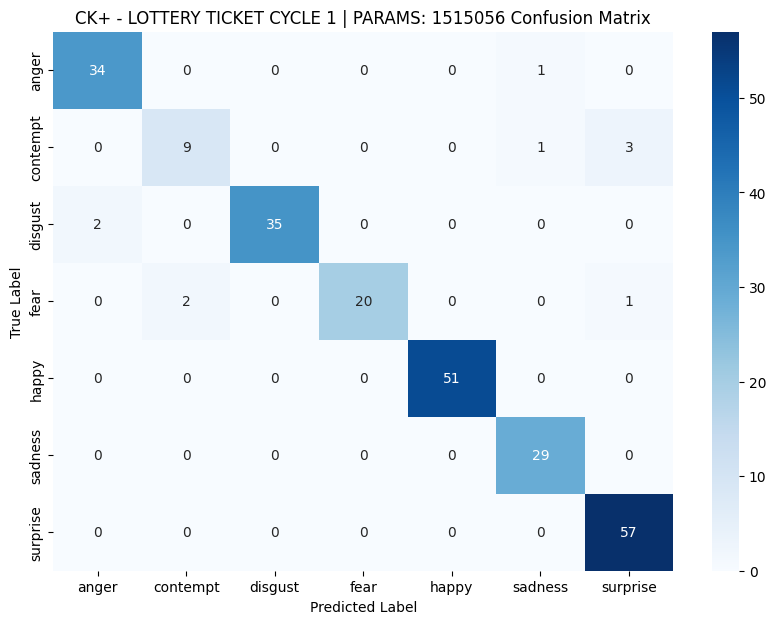

Test Accuracy: 0.9592
Precision: 0.9475
Recall: 0.9256
F1 Score: 0.9347
Classification Report:
               precision    recall  f1-score   support

       anger       0.94      0.97      0.96        35
    contempt       0.82      0.69      0.75        13
     disgust       1.00      0.95      0.97        37
        fear       1.00      0.87      0.93        23
       happy       1.00      1.00      1.00        51
     sadness       0.94      1.00      0.97        29
    surprise       0.93      1.00      0.97        57

    accuracy                           0.96       245
   macro avg       0.95      0.93      0.93       245
weighted avg       0.96      0.96      0.96       245

Evaluating model from cycle 2, Parameters: 1364157, Min Val Loss: 0.1325


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


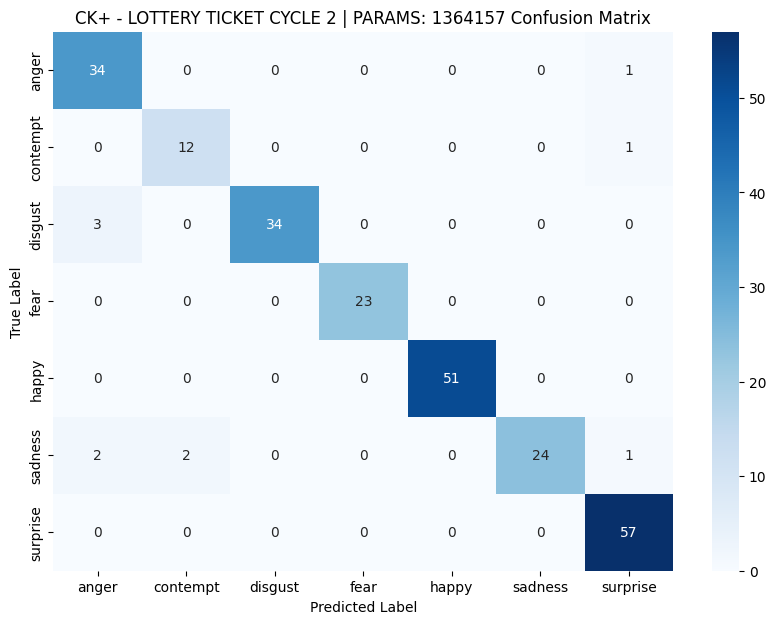

Test Accuracy: 0.9592
Precision: 0.9541
Recall: 0.9487
F1 Score: 0.9494
Classification Report:
               precision    recall  f1-score   support

       anger       0.87      0.97      0.92        35
    contempt       0.86      0.92      0.89        13
     disgust       1.00      0.92      0.96        37
        fear       1.00      1.00      1.00        23
       happy       1.00      1.00      1.00        51
     sadness       1.00      0.83      0.91        29
    surprise       0.95      1.00      0.97        57

    accuracy                           0.96       245
   macro avg       0.95      0.95      0.95       245
weighted avg       0.96      0.96      0.96       245

Evaluating model from cycle 3, Parameters: 1228348, Min Val Loss: 0.1474


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


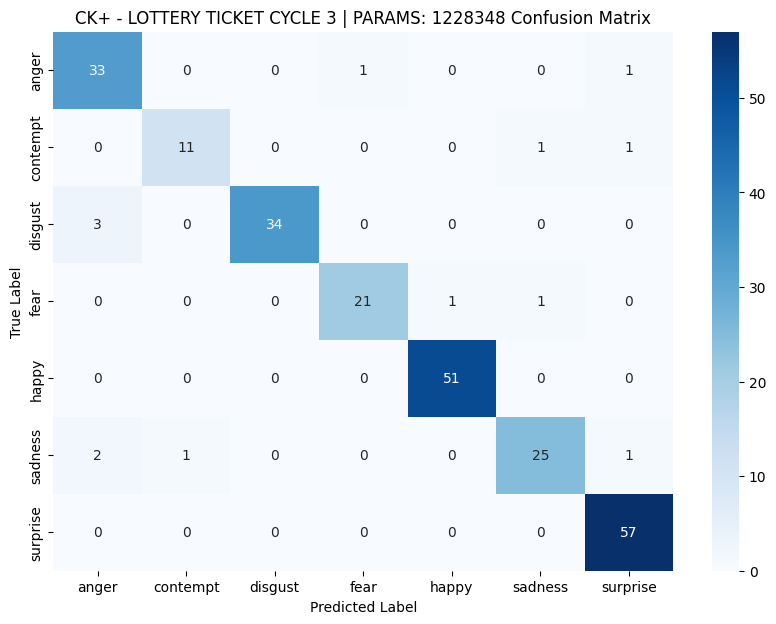

Test Accuracy: 0.9469
Precision: 0.9423
Recall: 0.9261
F1 Score: 0.9332
Classification Report:
               precision    recall  f1-score   support

       anger       0.87      0.94      0.90        35
    contempt       0.92      0.85      0.88        13
     disgust       1.00      0.92      0.96        37
        fear       0.95      0.91      0.93        23
       happy       0.98      1.00      0.99        51
     sadness       0.93      0.86      0.89        29
    surprise       0.95      1.00      0.97        57

    accuracy                           0.95       245
   macro avg       0.94      0.93      0.93       245
weighted avg       0.95      0.95      0.95       245

Evaluating model from cycle 4, Parameters: 1106117, Min Val Loss: 0.1210


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


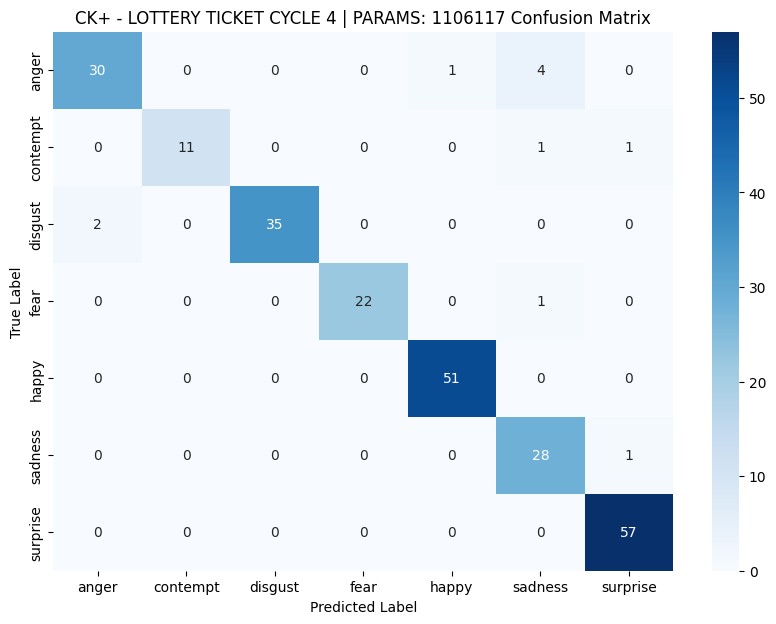

Test Accuracy: 0.9551
Precision: 0.9583
Recall: 0.9388
F1 Score: 0.9463
Classification Report:
               precision    recall  f1-score   support

       anger       0.94      0.86      0.90        35
    contempt       1.00      0.85      0.92        13
     disgust       1.00      0.95      0.97        37
        fear       1.00      0.96      0.98        23
       happy       0.98      1.00      0.99        51
     sadness       0.82      0.97      0.89        29
    surprise       0.97      1.00      0.98        57

    accuracy                           0.96       245
   macro avg       0.96      0.94      0.95       245
weighted avg       0.96      0.96      0.96       245

Evaluating model from cycle 5, Parameters: 996107, Min Val Loss: 0.0916


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


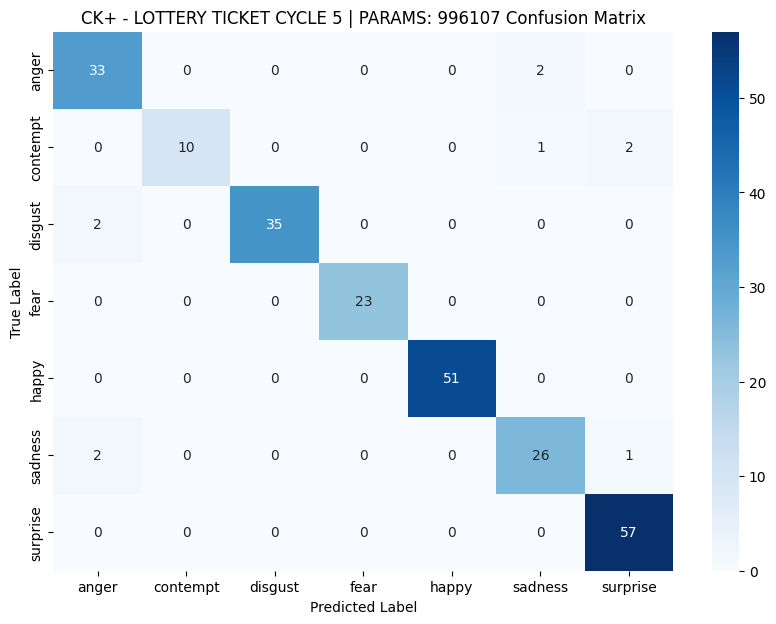

Test Accuracy: 0.9592
Precision: 0.9626
Recall: 0.9364
F1 Score: 0.9471
Classification Report:
               precision    recall  f1-score   support

       anger       0.89      0.94      0.92        35
    contempt       1.00      0.77      0.87        13
     disgust       1.00      0.95      0.97        37
        fear       1.00      1.00      1.00        23
       happy       1.00      1.00      1.00        51
     sadness       0.90      0.90      0.90        29
    surprise       0.95      1.00      0.97        57

    accuracy                           0.96       245
   macro avg       0.96      0.94      0.95       245
weighted avg       0.96      0.96      0.96       245

Evaluating model from cycle 6, Parameters: 897098, Min Val Loss: 0.0895


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


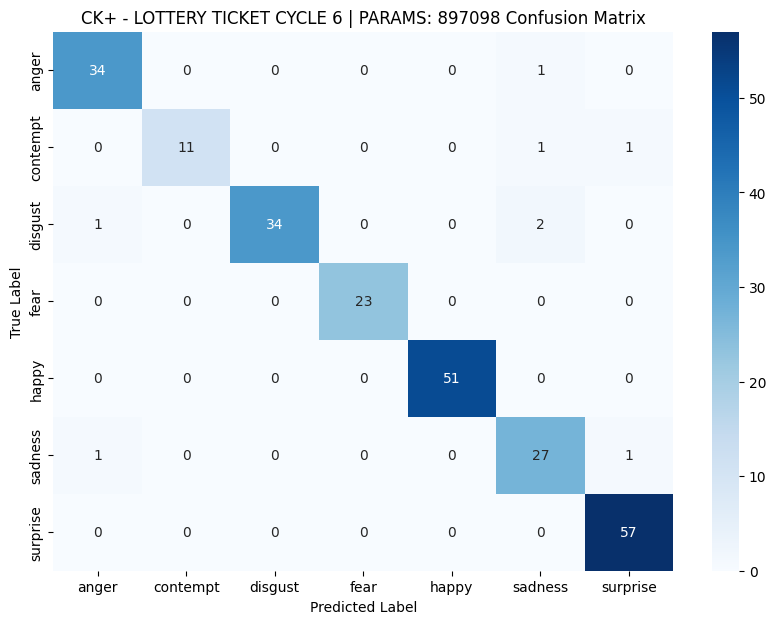

Test Accuracy: 0.9673
Precision: 0.9688
Recall: 0.9525
F1 Score: 0.9593
Classification Report:
               precision    recall  f1-score   support

       anger       0.94      0.97      0.96        35
    contempt       1.00      0.85      0.92        13
     disgust       1.00      0.92      0.96        37
        fear       1.00      1.00      1.00        23
       happy       1.00      1.00      1.00        51
     sadness       0.87      0.93      0.90        29
    surprise       0.97      1.00      0.98        57

    accuracy                           0.97       245
   macro avg       0.97      0.95      0.96       245
weighted avg       0.97      0.97      0.97       245

Evaluating model from cycle 7, Parameters: 807994, Min Val Loss: 0.1308


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


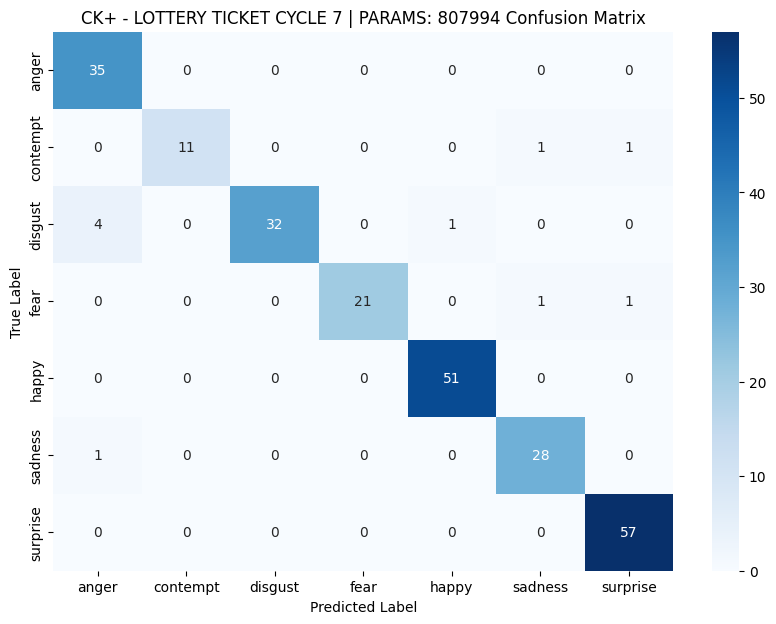

Test Accuracy: 0.9592
Precision: 0.9650
Recall: 0.9414
F1 Score: 0.9506
Classification Report:
               precision    recall  f1-score   support

       anger       0.88      1.00      0.93        35
    contempt       1.00      0.85      0.92        13
     disgust       1.00      0.86      0.93        37
        fear       1.00      0.91      0.95        23
       happy       0.98      1.00      0.99        51
     sadness       0.93      0.97      0.95        29
    surprise       0.97      1.00      0.98        57

    accuracy                           0.96       245
   macro avg       0.97      0.94      0.95       245
weighted avg       0.96      0.96      0.96       245

Evaluating model from cycle 8, Parameters: 727802, Min Val Loss: 0.1051


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


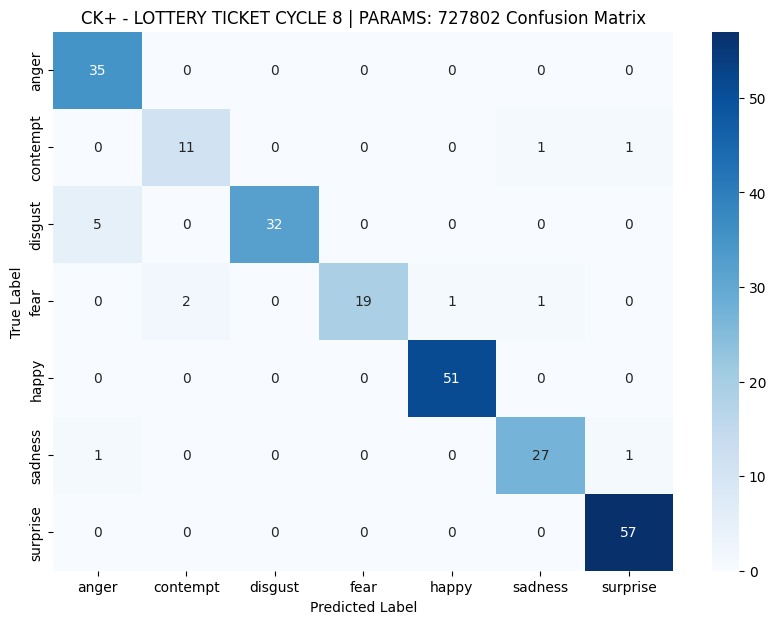

Test Accuracy: 0.9469
Precision: 0.9397
Recall: 0.9240
F1 Score: 0.9291
Classification Report:
               precision    recall  f1-score   support

       anger       0.85      1.00      0.92        35
    contempt       0.85      0.85      0.85        13
     disgust       1.00      0.86      0.93        37
        fear       1.00      0.83      0.90        23
       happy       0.98      1.00      0.99        51
     sadness       0.93      0.93      0.93        29
    surprise       0.97      1.00      0.98        57

    accuracy                           0.95       245
   macro avg       0.94      0.92      0.93       245
weighted avg       0.95      0.95      0.95       245

Evaluating model from cycle 9, Parameters: 655622, Min Val Loss: 0.1311


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


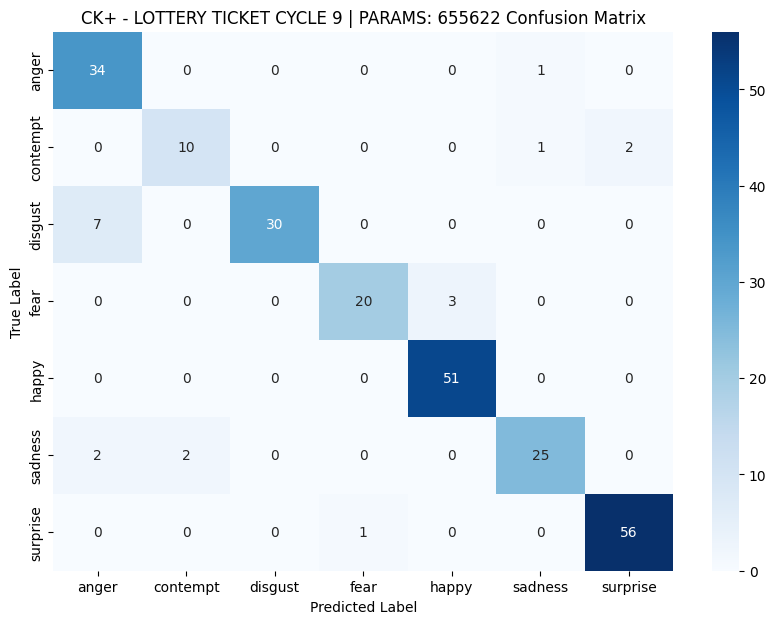

Test Accuracy: 0.9224
Precision: 0.9160
Recall: 0.8951
F1 Score: 0.9021
Classification Report:
               precision    recall  f1-score   support

       anger       0.79      0.97      0.87        35
    contempt       0.83      0.77      0.80        13
     disgust       1.00      0.81      0.90        37
        fear       0.95      0.87      0.91        23
       happy       0.94      1.00      0.97        51
     sadness       0.93      0.86      0.89        29
    surprise       0.97      0.98      0.97        57

    accuracy                           0.92       245
   macro avg       0.92      0.90      0.90       245
weighted avg       0.93      0.92      0.92       245

Evaluating model from cycle 10, Parameters: 590669, Min Val Loss: 0.1237


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


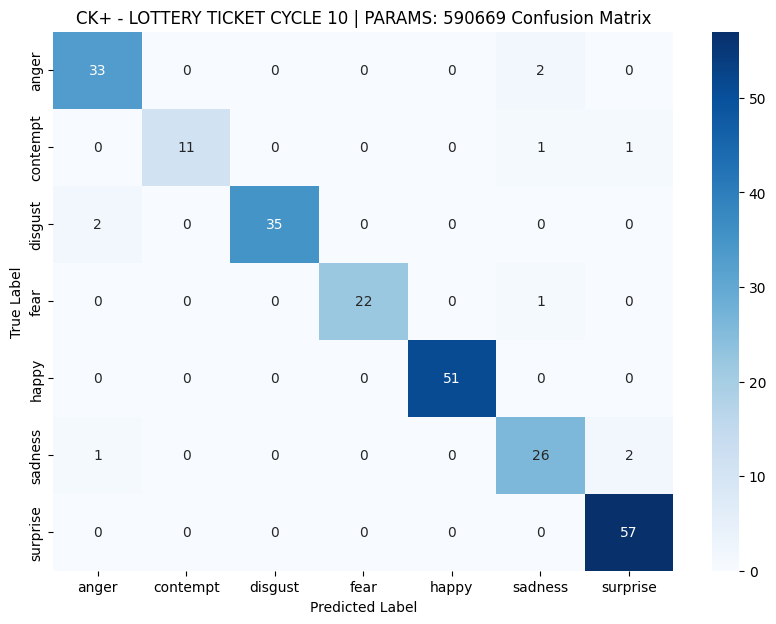

Test Accuracy: 0.9592
Precision: 0.9619
Recall: 0.9411
F1 Score: 0.9503
Classification Report:
               precision    recall  f1-score   support

       anger       0.92      0.94      0.93        35
    contempt       1.00      0.85      0.92        13
     disgust       1.00      0.95      0.97        37
        fear       1.00      0.96      0.98        23
       happy       1.00      1.00      1.00        51
     sadness       0.87      0.90      0.88        29
    surprise       0.95      1.00      0.97        57

    accuracy                           0.96       245
   macro avg       0.96      0.94      0.95       245
weighted avg       0.96      0.96      0.96       245

Evaluating model from cycle 11, Parameters: 532205, Min Val Loss: 0.1173


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


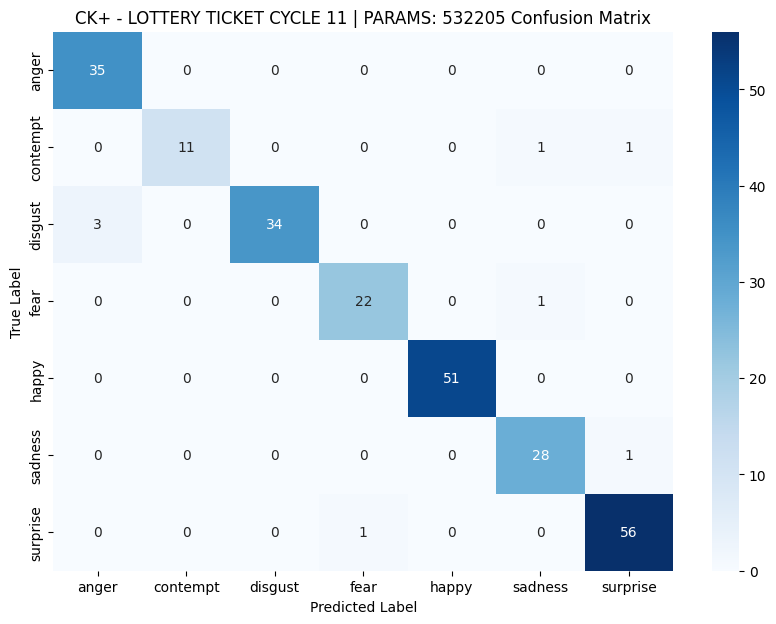

Test Accuracy: 0.9673
Precision: 0.9681
Recall: 0.9528
F1 Score: 0.9590
Classification Report:
               precision    recall  f1-score   support

       anger       0.92      1.00      0.96        35
    contempt       1.00      0.85      0.92        13
     disgust       1.00      0.92      0.96        37
        fear       0.96      0.96      0.96        23
       happy       1.00      1.00      1.00        51
     sadness       0.93      0.97      0.95        29
    surprise       0.97      0.98      0.97        57

    accuracy                           0.97       245
   macro avg       0.97      0.95      0.96       245
weighted avg       0.97      0.97      0.97       245

Evaluating model from cycle 12, Parameters: 479587, Min Val Loss: 0.0935


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


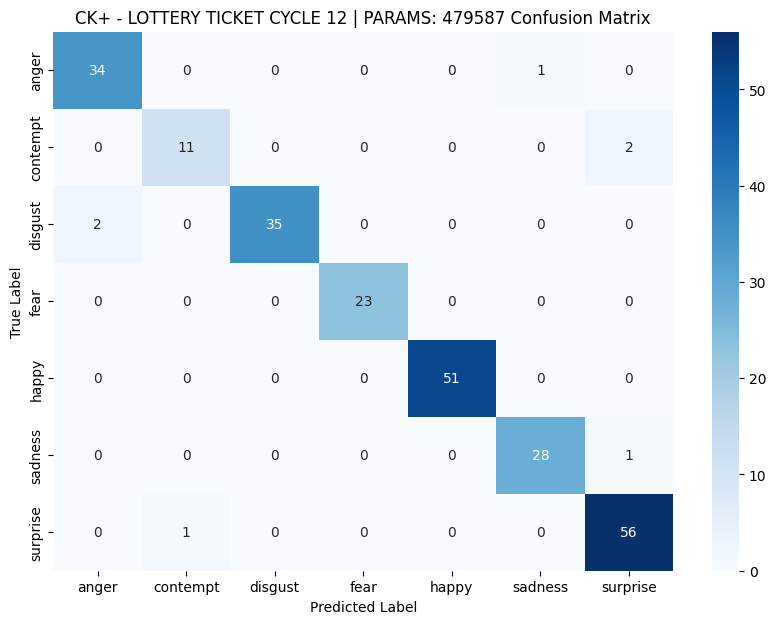

Test Accuracy: 0.9714
Precision: 0.9680
Recall: 0.9588
F1 Score: 0.9630
Classification Report:
               precision    recall  f1-score   support

       anger       0.94      0.97      0.96        35
    contempt       0.92      0.85      0.88        13
     disgust       1.00      0.95      0.97        37
        fear       1.00      1.00      1.00        23
       happy       1.00      1.00      1.00        51
     sadness       0.97      0.97      0.97        29
    surprise       0.95      0.98      0.97        57

    accuracy                           0.97       245
   macro avg       0.97      0.96      0.96       245
weighted avg       0.97      0.97      0.97       245

Evaluating model from cycle 13, Parameters: 432237, Min Val Loss: 0.1542


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


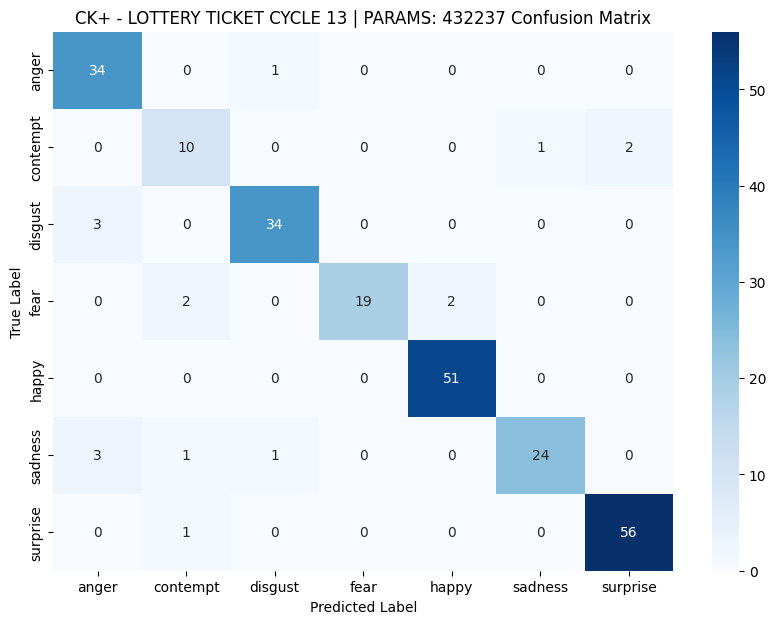

Test Accuracy: 0.9306
Precision: 0.9138
Recall: 0.8994
F1 Score: 0.9039
Classification Report:
               precision    recall  f1-score   support

       anger       0.85      0.97      0.91        35
    contempt       0.71      0.77      0.74        13
     disgust       0.94      0.92      0.93        37
        fear       1.00      0.83      0.90        23
       happy       0.96      1.00      0.98        51
     sadness       0.96      0.83      0.89        29
    surprise       0.97      0.98      0.97        57

    accuracy                           0.93       245
   macro avg       0.91      0.90      0.90       245
weighted avg       0.93      0.93      0.93       245

Evaluating model from cycle 14, Parameters: 389614, Min Val Loss: 4.4066


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0

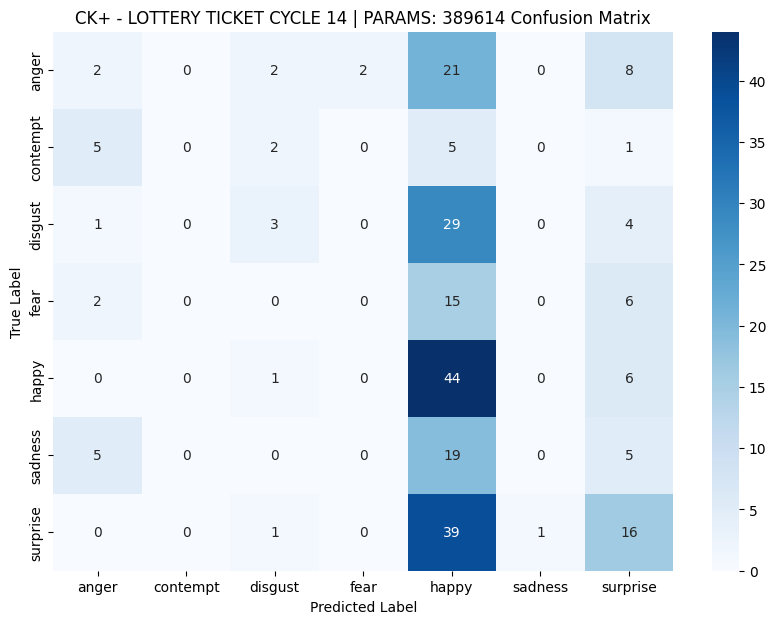

Test Accuracy: 0.2653
Precision: 0.1529
Recall: 0.1831
F1 Score: 0.1308
Classification Report:
               precision    recall  f1-score   support

       anger       0.13      0.06      0.08        35
    contempt       0.00      0.00      0.00        13
     disgust       0.33      0.08      0.13        37
        fear       0.00      0.00      0.00        23
       happy       0.26      0.86      0.39        51
     sadness       0.00      0.00      0.00        29
    surprise       0.35      0.28      0.31        57

    accuracy                           0.27       245
   macro avg       0.15      0.18      0.13       245
weighted avg       0.20      0.27      0.19       245

Evaluating model from cycle 15, Parameters: 351256, Min Val Loss: 4.3608


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0

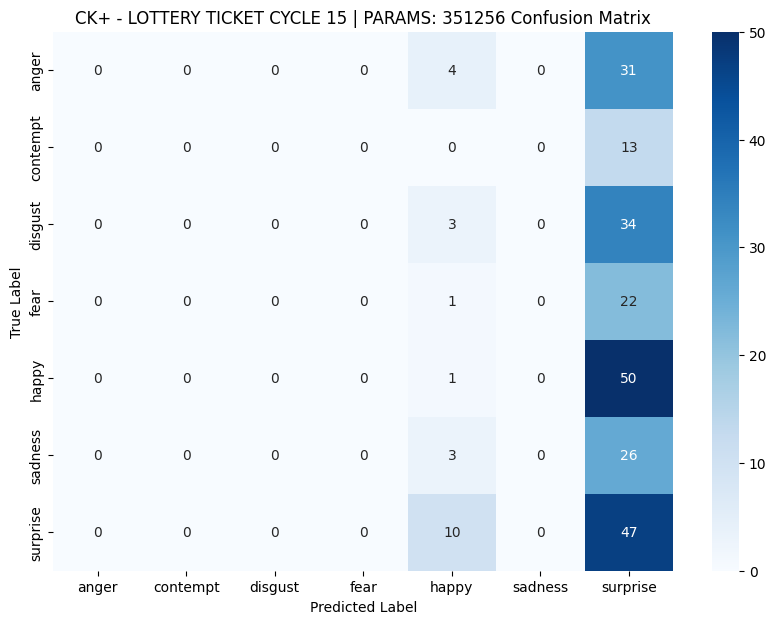

Test Accuracy: 0.1959
Precision: 0.0366
Recall: 0.1206
F1 Score: 0.0519
Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00        35
    contempt       0.00      0.00      0.00        13
     disgust       0.00      0.00      0.00        37
        fear       0.00      0.00      0.00        23
       happy       0.05      0.02      0.03        51
     sadness       0.00      0.00      0.00        29
    surprise       0.21      0.82      0.34        57

    accuracy                           0.20       245
   macro avg       0.04      0.12      0.05       245
weighted avg       0.06      0.20      0.08       245



In [10]:
def evaluate_all_models(best_models_dict, test_loader, device, data, label_encoder=None):
    for cycle, model_info in best_models_dict.items():
        model_state_dict = model_info['model']
        params = model_info['params']
        min_val_loss = model_info['min_val_loss']

        model = MobileNetV3(num_labels=len(label_encoder.classes_)).to(device)
        model.load_state_dict(model_state_dict)

        title = f'{data.upper()} - Lottery Ticket Cycle {cycle} | Params: {params}'

        print(f"Evaluating model from cycle {cycle}, Parameters: {params}, Min Val Loss: {min_val_loss:.4f}")

        evaluate_model(model, test_loader, device, title, label_encoder=label_encoder)


evaluate_all_models(best_models_dict, test_loader, device, data="CK+", label_encoder=label_encoder)


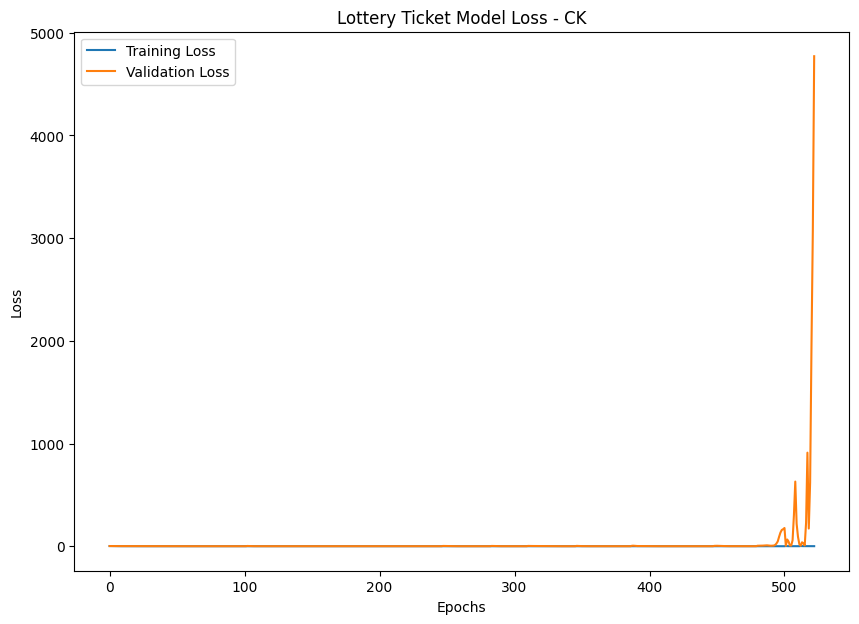

In [11]:
plot_losses(train_loss, val_loss, f'Lottery Ticket Model Loss - {data.upper()}')

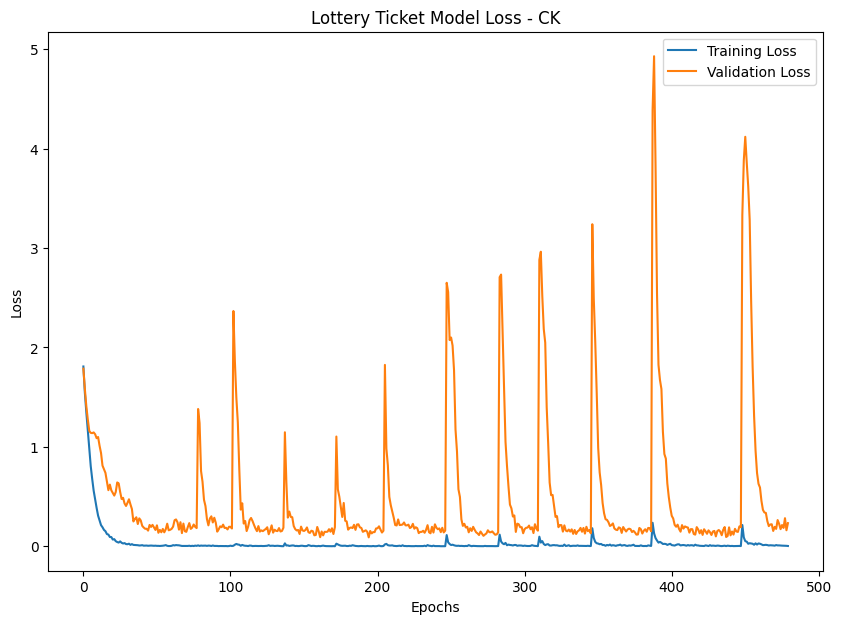

In [17]:
plot_losses(train_loss[:480], val_loss[:480], f'Lottery Ticket Model Loss - {data.upper()}')

In [13]:
min(train_loss)

0.0005427234086710087

In [14]:
min(val_loss)

0.08949215875327354